<a href="https://colab.research.google.com/github/bisht-prachi/Some-Statistical-Modeling-Projects-MITx-MicroMasters-/blob/main/Time_series_prediction_of_CO2_emission_in_Mauna_Lua_Inflation_rate_of_US_economy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

import math
# import pmdarima as pm
import statsmodels.api as sm

# Problem 4.1 Mauna Lua Co2

In [ ]:
cols = [
    "year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"
]

In [ ]:
# Initialize columns of dataframe
cols = [
    "year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"
]
keep_cols = ["year", "month", "co2"]
df_co2 = (
    pd.read_csv("/kaggle/input/mm-time-series-data/CO2.csv", skiprows=57, header=None, names=cols)
    .drop(columns=[col for col in cols if col not in keep_cols]) # Only keep column 5 and date columns
    .assign(co2=lambda df: df.co2.replace({-99.99: np.nan})) # -99.99 indicates a homogeneity - replace it with null
    .assign(time=lambda df: (df.index.values + 0.5) / 12) # Convert to time notation that question specifies
)
df_co2

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,year,month,co2,time
0,1958,1,NaN,0.041667
1,1958,2,NaN,0.125000
2,1958,3,315.70,0.208333
3,1958,4,317.45,0.291667
4,1958,5,317.51,0.375000
...,...,...,...,...
739,2019,8,410.08,61.625000
740,2019,9,408.55,61.708333
741,2019,10,NaN,61.791667
742,2019,11,NaN,61.875000


In [ ]:
df_co2.dropna(inplace=True,axis=0)

In [ ]:
df_co2

,year,month,co2,time
2,1958,3,315.70,0.208333
3,1958,4,317.45,0.291667
4,1958,5,317.51,0.375000
6,1958,7,315.86,0.541667
7,1958,8,314.93,0.625000
...,...,...,...,...
736,2019,5,414.83,61.375000
737,2019,6,413.96,61.458333
738,2019,7,411.85,61.541667
739,2019,8,410.08,61.625000


In [ ]:
df_co2.isna().sum()

year     0
month    0
co2      0
time     0
dtype: int64

## Linear Modeling

In [ ]:
train_size = int(0.8*len(df_co2))
test_szie = len(df_co2) - train_size

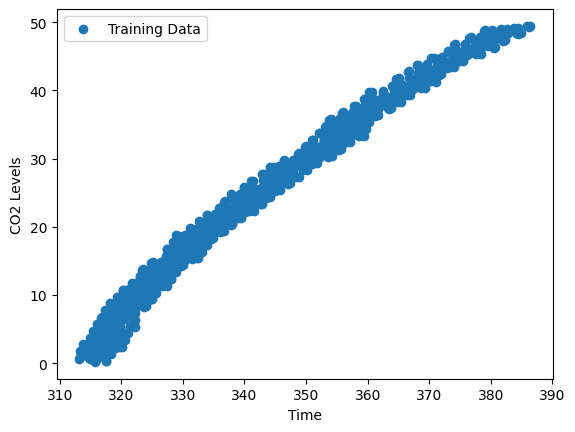

In [ ]:

# Selecting features and target
y = df_co2[['co2']].values  # Reshape to 2D array for sklearn
X = df_co2[['time']].values

# Splitting dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size: ]
y_test = y[train_size:]

# Plot data
plt.scatter(y_train, X_train, label="Training Data")
plt.xlabel("Time")
plt.ylabel("CO2 Levels")
plt.legend()
plt.show()


In [ ]:

# Fit Linear Regression Model
lin_reg_model = LinearRegression().fit(X_train, y_train)

# Predictions
y_pred = lin_reg_model.predict(X_test)

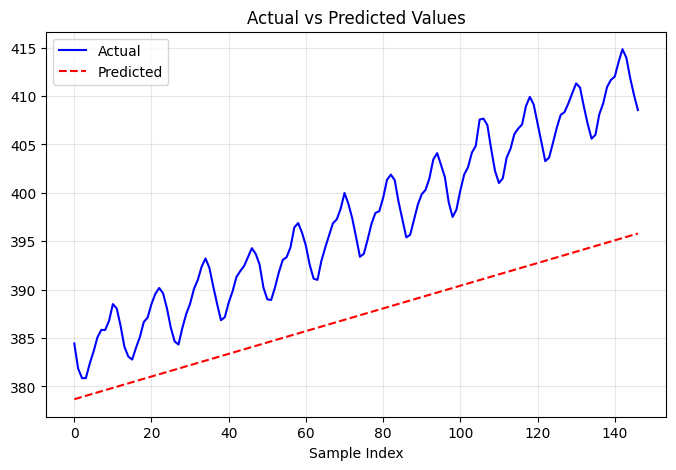

In [ ]:
plt.figure(figsize=(8, 5))

# Plot actual vs predicted values
plt.plot(y_test, label="Actual", color="blue", linestyle="-")
plt.plot(y_pred, label="Predicted", color="red", linestyle="--")

# Labels and title
plt.xlabel("Sample Index")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Model Evaluation
rmse_linear = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE_linear: {rmse_linear:.4f}")

# Model Evaluation
mape_linear = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE_linear: {mape_linear:.4f}")

RMSE_linear: 10.6415
MAPE_linear: 0.0245


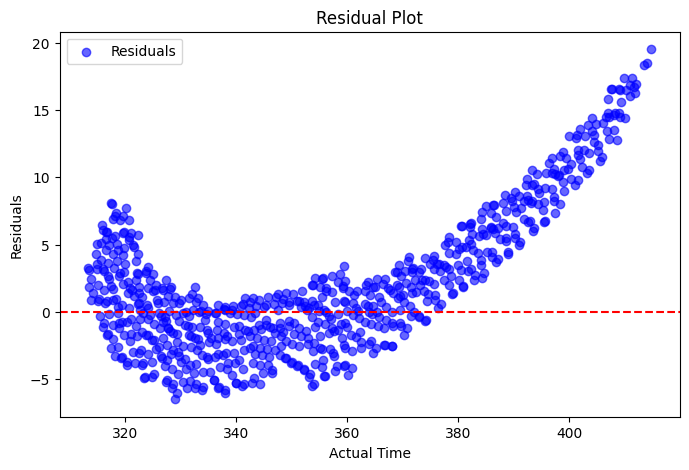

In [ ]:
# Flatten y and predictions
y_flat = y.ravel()
predictions_flat = lin_reg_model.predict(X).ravel()

# Compute residuals
residuals = y_flat - predictions_flat
# residuals = y -  lin_reg_model.predict(X)
# Plot residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_flat, residuals, color='blue', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)  # Reference line at y=0
plt.xlabel("Actual Time")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()

In [ ]:
lin_reg_model.coef_[0], lin_reg_model.intercept_

(array([1.40669115]), array([308.99165673]))

## Quadratic Modeling

In [ ]:
X_quad = PolynomialFeatures(degree=2).fit_transform(X)

X_train = X_quad[0:train_size]
y_train = y[0:train_size]
X_test = X_quad[train_size: ]
y_test = y[train_size:]


quad_reg_model = LinearRegression().fit(X_train,y_train)

y_pred_quad = quad_reg_model.predict(X_test)

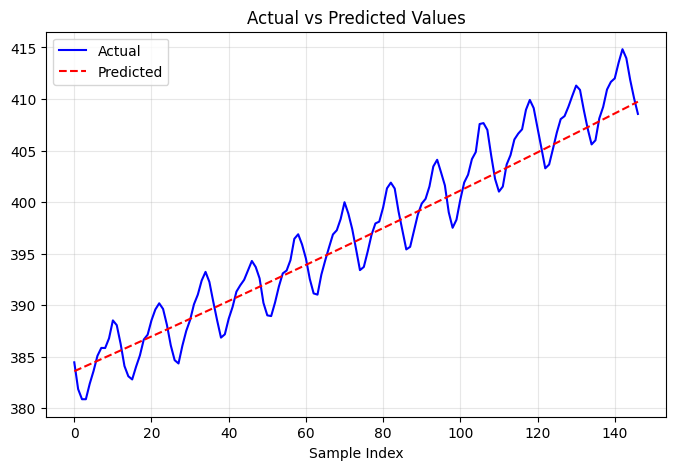

RMSE: 2.5013
MAPE: 0.0053


(array([[0.        , 0.80209702, 0.0121175 ]]), array([314.10058419]))

In [ ]:
plt.figure(figsize=(8, 5))

# Plot actual vs predicted values
plt.plot(y_test, label="Actual", color="blue", linestyle="-")
plt.plot(y_pred_quad, label="Predicted", color="red", linestyle="--")

# Labels and title
plt.xlabel("Sample Index")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

# Model Evaluation
rmse_quad = mean_squared_error(y_test, y_pred_quad, squared=False)
print(f"RMSE: {rmse_quad:.4f}")

# Model Evaluation
mape_quad = mean_absolute_percentage_error(y_test, y_pred_quad)
print(f"MAPE: {mape_quad:.4f}")

quad_reg_model.coef_, quad_reg_model.intercept_



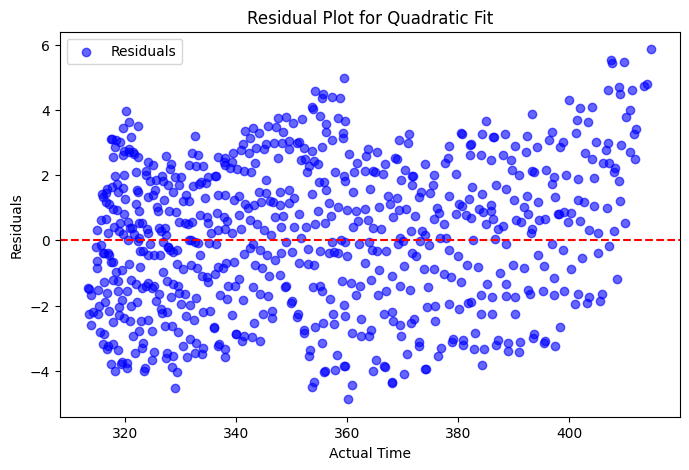

In [ ]:

# Make predictions with the quadratic model
predictions_quad = quad_reg_model.predict(X_quad)

# Compute residuals
residuals_quad = y.ravel() - predictions_quad.ravel()

# Plot residuals
plt.figure(figsize=(8, 5))
plt.scatter(y.ravel(), residuals_quad, color='blue', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)  # Reference line at y=0
plt.xlabel("Actual Time")
plt.ylabel("Residuals")
plt.title("Residual Plot for Quadratic Fit")
plt.legend()
plt.show()

## Cubic Model

In [ ]:
X_cubic = PolynomialFeatures(degree=3).fit_transform(X)

X_train = X_cubic[0:train_size]
y_train = y[0:train_size]
X_test = X_cubic[train_size: ]
y_test = y[train_size:]


cubic_reg_model = LinearRegression().fit(X_train,y_train)

y_pred_cubic = cubic_reg_model.predict(X_test)

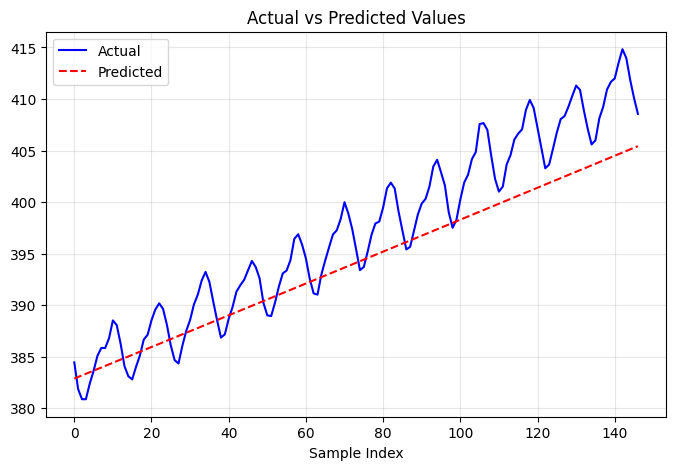

In [ ]:
plt.figure(figsize=(8, 5))

# Plot actual vs predicted values
plt.plot(y_test, label="Actual", color="blue", linestyle="-")
plt.plot(y_pred_cubic, label="Predicted", color="red", linestyle="--")

# Labels and title
plt.xlabel("Sample Index")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

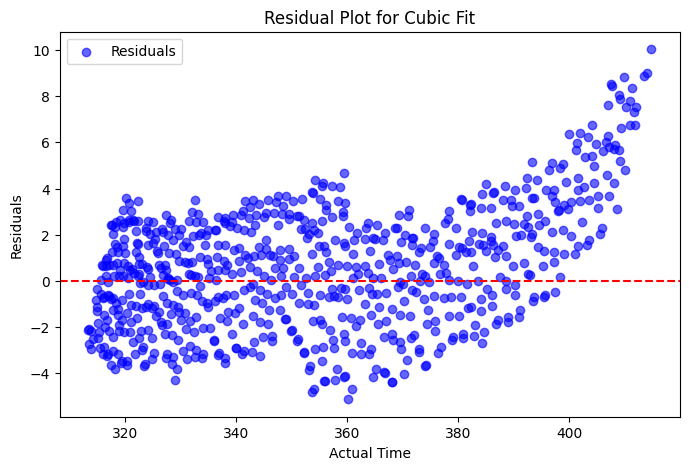

In [ ]:

# Make predictions with the quadratic model
predictions_cubic = cubic_reg_model.predict(X_cubic)

# Compute residuals
residuals_cubic = y.ravel() - predictions_cubic.ravel()

# Plot residuals
plt.figure(figsize=(8, 5))
plt.scatter(y.ravel(), residuals_cubic, color='blue', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)  # Reference line at y=0
plt.xlabel("Actual Time")
plt.ylabel("Residuals")
plt.title("Residual Plot for Cubic Fit")
plt.legend()
plt.show()

In [ ]:
rmse_cubic = mean_squared_error(y_test, y_pred_cubic, squared=False)
print(f"RMSE: {rmse_cubic:.4f}")

# Model Evaluation
mape_cubic = mean_absolute_percentage_error(y_test, y_pred_cubic)
print(f"MAPE: {mape_cubic:.4f}")

cubic_reg_model.coef_, cubic_reg_model.intercept_




RMSE: 4.1494
MAPE: 0.0085


(array([[ 0.00000000e+00,  6.24895409e-01,  2.09575674e-02,
         -1.18323397e-04]]),
 array([314.85852616]))

## Periodic component

In [ ]:
df_co2

,year,month,co2,time
2,1958,3,315.70,0.208333
3,1958,4,317.45,0.291667
4,1958,5,317.51,0.375000
6,1958,7,315.86,0.541667
7,1958,8,314.93,0.625000
...,...,...,...,...
736,2019,5,414.83,61.375000
737,2019,6,413.96,61.458333
738,2019,7,411.85,61.541667
739,2019,8,410.08,61.625000


In [ ]:
df_co2['residuals_quad'] = residuals_quad

In [ ]:
df_co2

,year,month,co2,time,residuals_quad
2,1958,3,315.70,0.208333,1.431786
3,1958,4,317.45,0.291667,3.114440
4,1958,5,317.51,0.375000,3.106925
6,1958,7,315.86,0.541667,1.321391
7,1958,8,314.93,0.625000,0.323372
...,...,...,...,...,...
736,2019,5,414.83,61.375000,5.855415
737,2019,6,413.96,61.458333,4.794538
738,2019,7,411.85,61.541667,2.493492
739,2019,8,410.08,61.625000,0.532278


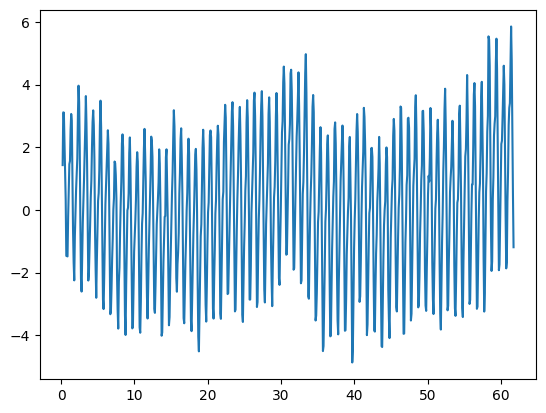

In [ ]:
plt.plot(df_co2['time'], df_co2['residuals_quad'])

In [ ]:
# df_co2_month_avg = df_co2[['month',	'residuals_quad']].groupby('month').mean()
# df_co2_month_avg = df_co2[:train_size].groupby('month')['residuals_quad'].mean()
# df_co2_month_avg = df_co2_month_avg.reset_index()
# df_co2_month_avg

# Compute average residuals for each month using only training data
df_co2_month_avg = df_co2.iloc[:train_size].groupby('month', as_index=False)['residuals_quad'].mean()

# Display the result
print(df_co2_month_avg)


    month  residuals_quad
0       1       -0.012919
1       2        0.646407
2       3        1.355569
3       4        2.561858
4       5        2.982891
5       6        2.316473
6       7        0.776297
7       8       -1.301213
8       9       -3.128074
9      10       -3.309520
10     11       -2.081487
11     12       -0.921507


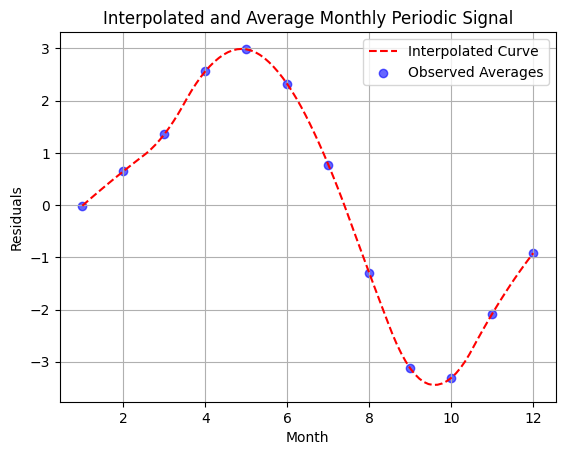

In [ ]:

# Create an interpolating function
months = df_co2_month_avg['month'].values
residuals = df_co2_month_avg['residuals_quad'].values

# Choose interpolation method: 'linear' or 'cubic' for smoother results
interpolator = interp1d(months, residuals, kind='quadratic', fill_value='interpolate')

# Generate smooth values for plotting
smooth_months = np.linspace(1, 12, 100)  # 100 points between 1 and 12
smooth_residuals = interpolator(smooth_months)

# Plot the interpolated periodic signal
plt.plot(smooth_months, smooth_residuals, color='red', linestyle='--', linewidth=1.5, label="Interpolated Curve")
plt.scatter(df_co2_month_avg['month'], df_co2_month_avg['residuals_quad'], c='blue', alpha=0.6, label="Observed Averages")

# plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.grid()
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.title('Interpolated and Average Monthly Periodic Signal')
plt.legend()
plt.show()

In [ ]:
X_quad = PolynomialFeatures(degree=2).fit_transform(X)

X_train = X_quad[0:train_size]
y_train = y[0:train_size]
X_test = X_quad[train_size: ]
y_test = y[train_size:]


quad_reg_model = LinearRegression().fit(X_train,y_train)

y_pred_quad = quad_reg_model.predict(X_test)
y_train_quad = quad_reg_model.predict(X_train)

In [ ]:
df_co2

,year,month,co2,time,residuals_quad
2,1958,3,315.70,0.208333,1.431786
3,1958,4,317.45,0.291667,3.114440
4,1958,5,317.51,0.375000,3.106925
6,1958,7,315.86,0.541667,1.321391
7,1958,8,314.93,0.625000,0.323372
...,...,...,...,...,...
736,2019,5,414.83,61.375000,5.855415
737,2019,6,413.96,61.458333,4.794538
738,2019,7,411.85,61.541667,2.493492
739,2019,8,410.08,61.625000,0.532278


In [ ]:
monthly_residuals = dict(zip(df_co2_month_avg['month'], df_co2_month_avg['residuals_quad']))

# Compute periodic component for entire dataset
periodic_adjustment = np.array([monthly_residuals.get(m, 0) for m in df_co2['month']])



# Compute final predictions (Quadratic Trend + Periodic)
y_final_train = y_train_quad.reshape(-1,) + periodic_adjustment[:train_size].reshape(-1,)
y_final_test = y_pred_quad.reshape(-1,) + periodic_adjustment[train_size:].reshape(-1,)


In [ ]:

# Plot the results
plt.figure(figsize=(15, 8))

# Actual data
plt.scatter(range(len(y)), y, color='gray', alpha=0.5, label="Actual Data")

# Quadratic Trend (without periodic component)
plt.plot(range(len(y)), np.concatenate([y_train_quad, y_pred_quad]),linestyle='dashed', color='blue', alpha=0.7, label="Quadratic Trend")

# Final Model (Quadratic + Periodic)
plt.plot(range(train_size), y_final_train, color='green',  alpha=0.7, label="Final Model (Train)")
plt.plot(range(train_size, len(y)), np.array(y_final_test), color='red', alpha=0.7, label="Final Model (Test)")

# Indicate training/testing split
plt.axvline(train_size, color='black', linestyle='--', label="Train-Test Split")

# Labels and title
plt.xlabel("Months since Mar 1958")
plt.ylabel("Atmospheric CO2 concentration (ppm)")
plt.title("Final Fit: Quadratic Trend + Periodic Component")
plt.legend()
plt.grid()
plt.show()

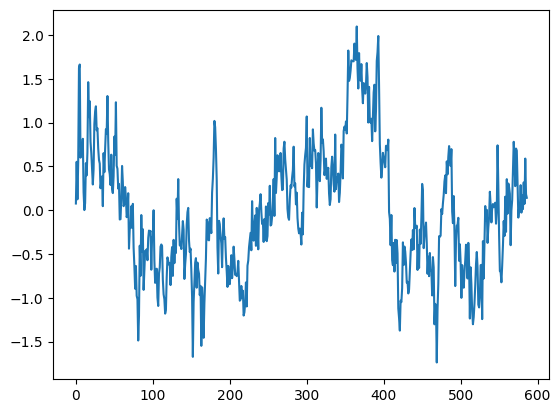

In [ ]:
plt.plot(y_train.reshape(-1,1) - y_final_train.reshape(-1,1))
plt.show()
# plt.plot(y_final_train)

In [ ]:
print ("Amplitude of Trend : ")
Amp_trend=y_train_quad.max()-y_train_quad.min()
print(Amp_trend)
print ("\nAmplitude of Periodic Signal : ")
Amp_p=max(periodic_adjustment[:train_size])-min(periodic_adjustment[:train_size])
print(Amp_p)

print ("\nRatio of amplitudes of trend to periodic signal : ")
print(Amp_trend/Amp_p)

print ("\nAmplitude of Residuals : ")
res = y_train.reshape(-1,1) - y_final_train.reshape(-1,1)
Amp_res=res.max()-res.min()
print(Amp_res)

print ("\nRatio of amplitudes of periodic signal  to residuals : ")
print(Amp_p/Amp_res)


print ("\nMedian of absolute value of Periodic Signal : ")
median_abs_p=np.median(np.abs(periodic_adjustment[:train_size]))
print(median_abs_p)
print ("\nMedian of absolute Residual : ")
median_abs_r=np.median(np.abs(res))
print(median_abs_r)
print ("\nRatio of median of periodic signal  to residuals : ")
print(median_abs_p/median_abs_r)


print (f"\nMean of absolute value of Periodic Signal : {np.mean(np.abs(periodic_adjustment[:train_size]))}")

print (f"\nMean of absolute Residual : {np.mean(np.abs(res))}")

print (f"\nRatio of mean of periodic signal to residuals : {np.mean(np.abs(periodic_adjustment[:train_size]))/np.mean(np.abs(res))}")


Amplitude of Trend : 
69.14369234539134

Amplitude of Periodic Signal : 
6.292410667159604

Ratio of amplitudes of trend to periodic signal : 
10.988426535199874

Amplitude of Residuals : 
3.836399237579542

Ratio of amplitudes of periodic signal  to residuals : 
1.6401866118422042

Median of absolute value of Periodic Signal : 
2.081486740992028

Median of absolute Residual : 
0.49333288570340983

Ratio of median of periodic signal  to residuals : 
4.2192337087445075

Mean of absolute value of Periodic Signal : 1.7842307512262106

Mean of absolute Residual : 0.5772398392373443

Ratio of mean of periodic signal to residuals : 3.090969524181761


In [ ]:
# Model Evaluation
rmse_quad_periodic = mean_squared_error(y_test, y_final_test, squared=False)
print(f"RMSE: {rmse_quad_periodic:.4f}")

# Model Evaluation
mape_quad_periodic = mean_absolute_percentage_error(y_test, y_final_test)
print(f"MAPE: {mape_quad_periodic:.4f}")


RMSE: 1.1494
MAPE: 0.0021


# Problem 4.2: CPI

In [ ]:
df_cpi = pd.read_csv('/kaggle/input/mm-time-series-data/CPI.csv', index_col=None)
df_cpi['date'] = pd.to_datetime(df_cpi['date'])
df_cpi = df_cpi.sort_values('date')

In [ ]:
df_cpi.dropna(axis=0,inplace=True)

In [ ]:
df_cpi.head(10)

,date,CPI
0,2008-07-24,100.0000
1,2008-07-25,100.0000
2,2008-07-26,100.0000
3,2008-07-27,100.0000
4,2008-07-28,100.0000
5,2008-07-29,100.0000
6,2008-07-30,100.0000
7,2008-07-31,100.0000
8,2008-08-01,100.5251
9,2008-08-02,100.5251


In [ ]:
df_cpi.isna().sum()

date    0
CPI     0
dtype: int64

In [ ]:
df_monthly_cpi = df_cpi.groupby(df_cpi['date'].dt.to_period('M')).first().rename_axis('YearMonth').reset_index()
df_monthly_cpi

,YearMonth,date,CPI
0,2008-07,2008-07-24,100.00000
1,2008-08,2008-08-01,100.52510
2,2008-09,2008-09-01,100.12380
3,2008-10,2008-10-01,99.98538
4,2008-11,2008-11-01,98.97539
...,...,...,...
131,2019-06,2019-06-01,117.03590
132,2019-07,2019-07-01,117.05920
133,2019-08,2019-08-01,117.25480
134,2019-09,2019-09-01,117.24880


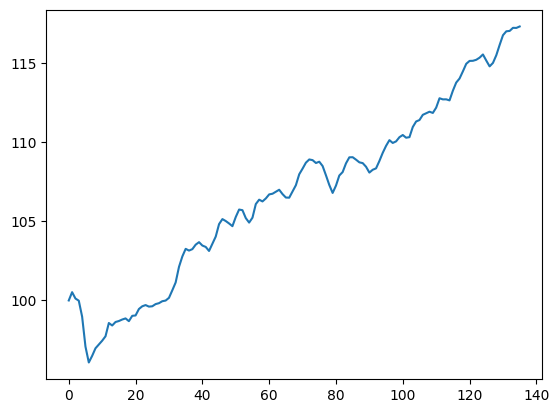

In [ ]:
plt.plot(df_monthly_cpi.CPI)

In [ ]:

# Convert date to number of months since the start
# df_monthly_cpi['months_since_start'] = (df_monthly_cpi['date'].dt.year - df_monthly_cpi['date'].dt.year.min()) * 12 + df_monthly_cpi['date'].dt.month

# Define training data (before September 2013)
cpi_train = (df_monthly_cpi[df_monthly_cpi.YearMonth<'2013-09'].copy())
cpi_test = (df_monthly_cpi[df_monthly_cpi.YearMonth>='2013-09'].copy())

# Define X (months since start) and y (CPI values)
X_train = np.array(cpi_train.index).reshape(-1, 1)#train_data[['months_since_start']].copy()
y_train = cpi_train['CPI'].copy()



# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Get slope (m) and intercept (b)
m = lin_reg.coef_[0]
b = lin_reg.intercept_

print(f"m = {m}, b = {b}")


m = 0.1610434836695122, b = 96.72932632872505


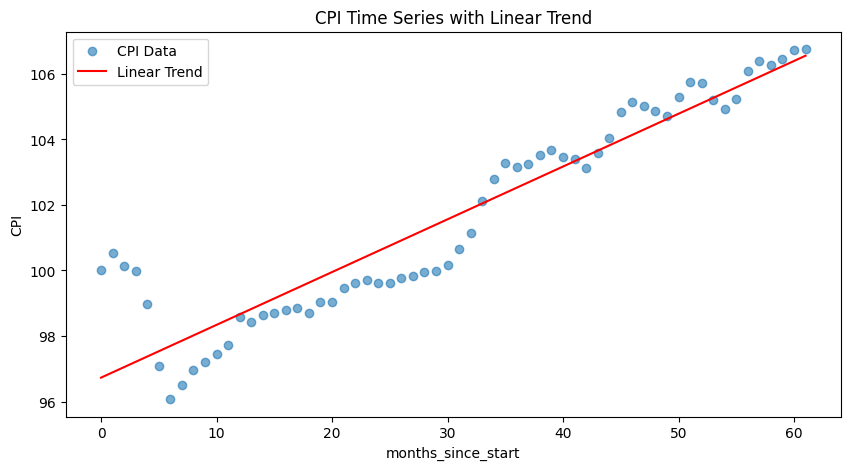

In [ ]:

# Plot the data and linear trend
plt.figure(figsize=(10, 5))
plt.scatter(cpi_train.index, cpi_train['CPI'], label="CPI Data", alpha=0.6)
plt.plot(cpi_train.index, lin_reg.predict(X_train), color='red', label="Linear Trend")
plt.xlabel("months_since_start")
plt.ylabel("CPI")
plt.title("CPI Time Series with Linear Trend")
plt.legend()
plt.show()


Max absolute residual: 3.6347301876054274


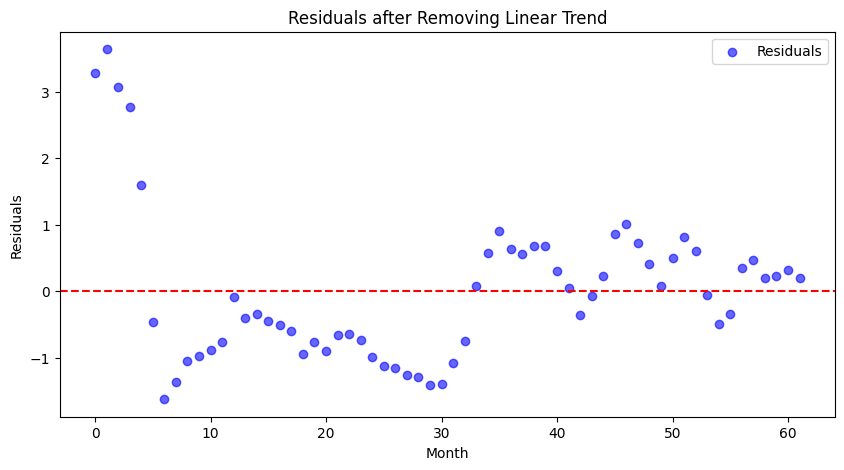

In [ ]:
# Compute residuals
cpi_train['residuals'] = cpi_train['CPI'] - lin_reg.predict(X_train)

# Find max absolute residual in training data
max_abs_residual = np.max(np.abs(cpi_train['residuals']))

# Print max absolute residual rounded to 3 significant figures
print(f"Max absolute residual: {max_abs_residual}")

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(cpi_train.index, cpi_train['residuals'], color='blue', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Month")
plt.ylabel("Residuals")
plt.title("Residuals after Removing Linear Trend")
plt.legend()
plt.show()


## AR model

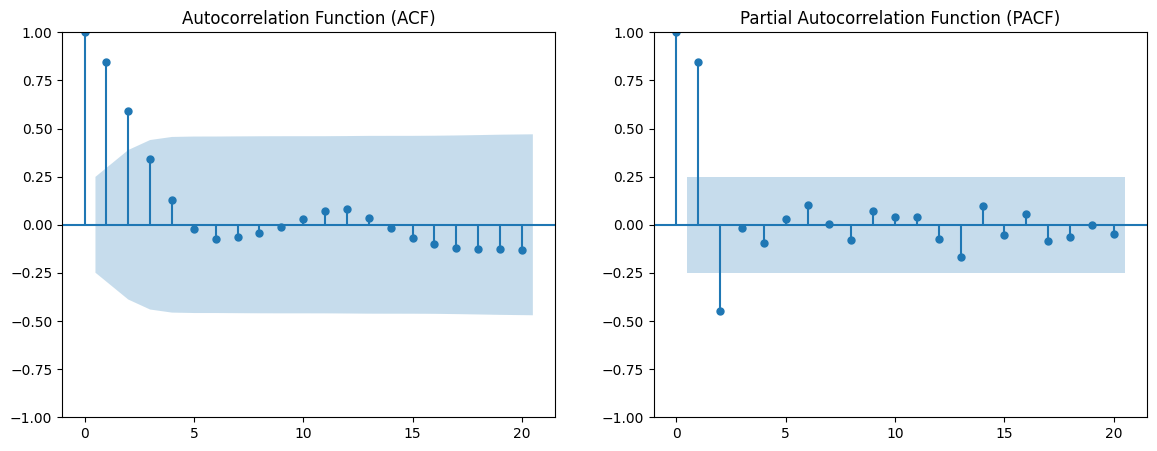

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(cpi_train['residuals'], ax=axes[0], lags=20)
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(cpi_train['residuals'], ax=axes[1], lags=20, method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [ ]:
# Fit the AR(2) model
ar_model = AutoReg(cpi_train['residuals'], lags=2).fit()

# Report the coefficients (AR terms and constant)
ar_coefficients = ar_model.params
print(f"AR(2) Coefficients:\n{ar_coefficients}")



AR(2) Coefficients:
const          -0.043105
residuals.L1    1.323666
residuals.L2   -0.530797
dtype: float64


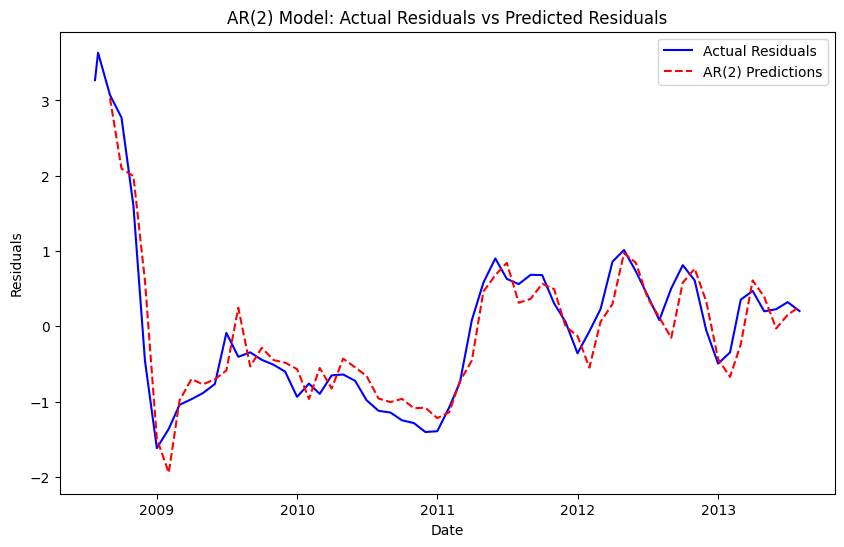

In [ ]:
# Predict the residuals using the fitted AR model
predictions = ar_model.predict(start=0, end=len(cpi_train)-1)

# Plot the actual residuals and AR model predictions
plt.figure(figsize=(10, 6))
plt.plot(cpi_train['date'], cpi_train['residuals'], label="Actual Residuals", color='blue')
plt.plot(cpi_train['date'], predictions, label="AR(2) Predictions", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("AR(2) Model: Actual Residuals vs Predicted Residuals")
plt.legend()
plt.show()


In [ ]:
np.sqrt(mean_squared_error(cpi_train['residuals'][2:], predictions[2:]))

0.32375161093043087

In [ ]:
coef = ar_model.params
coef

const          -0.043105
residuals.L1    1.323666
residuals.L2   -0.530797
dtype: float64

In [ ]:
# Given AR(2) coefficients
coef = ar_model.params
coef
cpi_intercept = coef[0]
cpi_lag1_coef = coef[1]
cpi_lag2_coef = coef[2]

def one_month_ahead_forecast(train_df, test_df, trend_model):
    predictions = []
    actuals = []

    # Initialize past values with training data
    train_residuals = train_df['CPI'] - trend_model.predict(train_df.index.values.reshape(-1, 1))
    past_residuals = train_residuals.iloc[-2:].tolist()  # Last two residuals

    test_df = test_df.copy()  # Ensure test_df is not modified in place
    test_df['cpi_pred'] = np.nan  # Initialize prediction column

    for i in range(len(test_df)):
        test_index = test_df.index[i]

        # Predict the linear trend for the test month
        trend_pred = trend_model.predict(np.array([[test_index]]))[0]

        # Apply AR(2) to predict the residual
        ar_pred = (cpi_lag1_coef * past_residuals[-1]) + (cpi_lag2_coef * past_residuals[-2]) + cpi_intercept

        # Compute final prediction
        final_pred = trend_pred + ar_pred

        # Store the prediction in the corresponding row
        test_df.loc[test_index, 'cpi_pred'] = final_pred

        # Store predictions and actual values
        predictions.append(final_pred)
        actuals.append(test_df.iloc[i]['CPI'])

        # Update past residuals for next month
        new_residual = test_df.iloc[i]['CPI'] - trend_pred  # Compute actual residual
        past_residuals.append(new_residual)
        past_residuals.pop(0)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse, test_df

# Split data into training (before Sep 2013) and validation (from Sep 2013)
train_df = df_monthly_cpi[df_monthly_cpi['YearMonth'] < '2013-09']
test_df = df_monthly_cpi[df_monthly_cpi['YearMonth'] >= '2013-09']

# Compute RMSE
rmse_1_month_ahead, test_df = one_month_ahead_forecast(train_df, test_df, lin_reg)
print(f"Root Mean Squared Prediction Error (1-Month-Ahead Forecasts): {rmse_1_month_ahead}")


Root Mean Squared Prediction Error (1-Month-Ahead Forecasts): 0.39104043069964745


<ipython-input-50-dad56fa52821>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cpi_intercept = coef[0]
<ipython-input-50-dad56fa52821>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cpi_lag1_coef = coef[1]
<ipython-input-50-dad56fa52821>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cpi_lag2_coef = coef[2]


In [ ]:
test_df

,YearMonth,date,CPI,cpi_pred
62,2013-09,2013-09-01,106.8835,106.768038
63,2013-10,2013-10-01,107.0078,106.949007
64,2013-11,2013-11-01,106.7322,107.078742
65,2013-12,2013-12-01,106.5142,106.681319
66,2014-01,2014-01-01,106.5051,106.572405
...,...,...,...,...
131,2019-06,2019-06-01,117.0359,117.328099
132,2019-07,2019-07-01,117.0592,117.363973
133,2019-08,2019-08-01,117.2548,117.296215
134,2019-09,2019-09-01,117.2488,117.576114


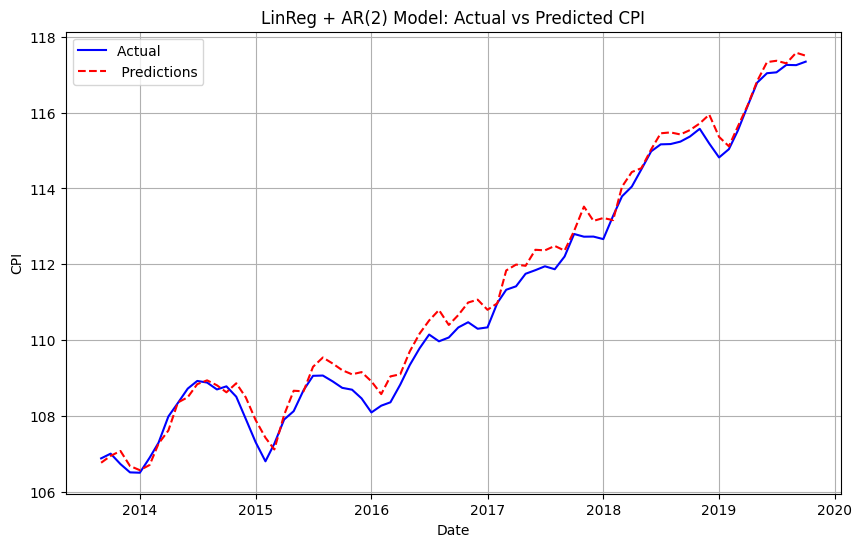

In [ ]:
# Plot the actual residuals and AR model predictions
plt.figure(figsize=(10, 6))
plt.plot(test_df['date'], test_df['CPI'], label="Actual ", color='blue')
plt.plot(test_df['date'], test_df['cpi_pred'], label=" Predictions", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid()
plt.title("LinReg + AR(2) Model: Actual vs Predicted CPI")
plt.legend()
plt.show()

## Inflation Rate

In [ ]:
df_monthly_cpi

,YearMonth,date,CPI
0,2008-07,2008-07-24,100.00000
1,2008-08,2008-08-01,100.52510
2,2008-09,2008-09-01,100.12380
3,2008-10,2008-10-01,99.98538
4,2008-11,2008-11-01,98.97539
...,...,...,...
131,2019-06,2019-06-01,117.03590
132,2019-07,2019-07-01,117.05920
133,2019-08,2019-08-01,117.25480
134,2019-09,2019-09-01,117.24880


In [ ]:
df_monthly_cpi['inflation'] = df_monthly_cpi['CPI'].diff()/df_monthly_cpi['CPI'].shift(1)

In [ ]:
df_monthly_cpi

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,YearMonth,date,CPI,inflation
0,2008-07,2008-07-24,100.00000,NaN
1,2008-08,2008-08-01,100.52510,0.005251
2,2008-09,2008-09-01,100.12380,-0.003992
3,2008-10,2008-10-01,99.98538,-0.001382
4,2008-11,2008-11-01,98.97539,-0.010101
...,...,...,...,...
131,2019-06,2019-06-01,117.03590,0.002129
132,2019-07,2019-07-01,117.05920,0.000199
133,2019-08,2019-08-01,117.25480,0.001671
134,2019-09,2019-09-01,117.24880,-0.000051


In [ ]:
df_monthly_cpi['log_inflation'] = np.log(df_monthly_cpi['CPI']).diff()

In [ ]:
df_monthly_cpi

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,YearMonth,date,CPI,inflation,log_inflation
0,2008-07,2008-07-24,100.00000,NaN,NaN
1,2008-08,2008-08-01,100.52510,0.005251,0.005237
2,2008-09,2008-09-01,100.12380,-0.003992,-0.004000
3,2008-10,2008-10-01,99.98538,-0.001382,-0.001383
4,2008-11,2008-11-01,98.97539,-0.010101,-0.010153
...,...,...,...,...,...
131,2019-06,2019-06-01,117.03590,0.002129,0.002126
132,2019-07,2019-07-01,117.05920,0.000199,0.000199
133,2019-08,2019-08-01,117.25480,0.001671,0.001670
134,2019-09,2019-09-01,117.24880,-0.000051,-0.000051


In [ ]:
df_monthly_cpi.loc[df_monthly_cpi['YearMonth']=='2013-02']

,YearMonth,date,CPI,inflation,log_inflation
55,2013-02,2013-02-01,105.2396,0.002957,0.002953


In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df_monthly_cpi['date'], df_monthly_cpi['inflation']*100, c="blue",lw =2.5, label='inflation rate')
plt.plot(df_monthly_cpi['date'], df_monthly_cpi['log_inflation']*100, ls='--', c="red",lw =1.5, label='inflation rate (log)')
plt.grid()
plt.ylabel('%')
plt.xlabel('date')
plt.legend()
plt.show()

In [ ]:
df_monthly_cpi.fillna(method='bfill', inplace=True)

<ipython-input-60-7cb7fbb853ad>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_monthly_cpi.fillna(method='bfill', inplace=True)


In [ ]:
cpi_ir_train = (df_monthly_cpi[df_monthly_cpi.YearMonth<'2013-09'].copy())
cpi_ir_test = (df_monthly_cpi[df_monthly_cpi.YearMonth >='2013-09'].copy())
cpi_ir_train

,YearMonth,date,CPI,inflation,log_inflation
0,2008-07,2008-07-24,100.00000,0.005251,0.005237
1,2008-08,2008-08-01,100.52510,0.005251,0.005237
2,2008-09,2008-09-01,100.12380,-0.003992,-0.004000
3,2008-10,2008-10-01,99.98538,-0.001382,-0.001383
4,2008-11,2008-11-01,98.97539,-0.010101,-0.010153
...,...,...,...,...,...
57,2013-04,2013-04-01,106.37890,0.002614,0.002611
58,2013-05,2013-05-01,106.26830,-0.001040,-0.001040
59,2013-06,2013-06-01,106.45750,0.001780,0.001779
60,2013-07,2013-07-01,106.71300,0.002400,0.002397


In [ ]:
cpi_ir_test

,YearMonth,date,CPI,inflation,log_inflation
62,2013-09,2013-09-01,106.8835,0.001203,0.001202
63,2013-10,2013-10-01,107.0078,0.001163,0.001162
64,2013-11,2013-11-01,106.7322,-0.002576,-0.002579
65,2013-12,2013-12-01,106.5142,-0.002042,-0.002045
66,2014-01,2014-01-01,106.5051,-0.000085,-0.000085
...,...,...,...,...,...
131,2019-06,2019-06-01,117.0359,0.002129,0.002126
132,2019-07,2019-07-01,117.0592,0.000199,0.000199
133,2019-08,2019-08-01,117.2548,0.001671,0.001670
134,2019-09,2019-09-01,117.2488,-0.000051,-0.000051


In [ ]:
cpi_ir_train

,YearMonth,date,CPI,inflation,log_inflation
0,2008-07,2008-07-24,100.00000,0.005251,0.005237
1,2008-08,2008-08-01,100.52510,0.005251,0.005237
2,2008-09,2008-09-01,100.12380,-0.003992,-0.004000
3,2008-10,2008-10-01,99.98538,-0.001382,-0.001383
4,2008-11,2008-11-01,98.97539,-0.010101,-0.010153
...,...,...,...,...,...
57,2013-04,2013-04-01,106.37890,0.002614,0.002611
58,2013-05,2013-05-01,106.26830,-0.001040,-0.001040
59,2013-06,2013-06-01,106.45750,0.001780,0.001779
60,2013-07,2013-07-01,106.71300,0.002400,0.002397


In [ ]:
ber = pd.read_csv('/kaggle/input/mm-time-series-data/T10YIE.csv')
ber

,DATE,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71
...,...,...
4388,2019-10-29,1.61
4389,2019-10-30,1.57
4390,2019-10-31,1.54
4391,2019-11-01,1.59


In [ ]:
ber['DATE'] =pd.to_datetime(ber['DATE'])
ber['YearMonth'] = ber['DATE'].dt.strftime('%Y-%m')
ber = ber.drop(ber[ber.YearMonth< '2008-07'].index)
# ber = ber.fillna(method='bfill')
# print(ber)

ber_monthly = pd.DataFrame(columns =['YearMonth','BER'])
ber_monthly['BER'] =ber.groupby('YearMonth').T10YIE.mean().values
ber_monthly['YearMonth'] = df_monthly_cpi.YearMonth

ber_monthly.dropna(subset=['YearMonth'], inplace=True)


ber_monthly['IR_ber'] = ((ber_monthly.BER.values/100+1)**(1/12)-1)*100

ber_ir_train = (ber_monthly[ber_monthly.YearMonth<'2013-09'].copy())
ber_ir_test = (ber_monthly[ber_monthly.YearMonth >='2013-09'].copy())

print("The inflation rate from BER for the month of February in 2013 was %0.9f" % ber_monthly[ber_monthly.YearMonth == '2013-02']['IR_ber'] + " %")

The inflation rate from BER for the month of February in 2013 was 0.210441852 %


<ipython-input-65-e1e7d716f049>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("The inflation rate from BER for the month of February in 2013 was %0.9f" % ber_monthly[ber_monthly.YearMonth == '2013-02']['IR_ber'] + " %")


In [ ]:
ber_monthly

,YearMonth,BER,IR_ber
0,2008-07,2.438636,0.200983
1,2008-08,2.209524,0.182288
2,2008-09,1.836190,0.151743
3,2008-10,1.061818,0.088057
4,2008-11,0.638333,0.053039
...,...,...,...
131,2019-06,1.700000,0.140575
132,2019-07,1.752727,0.144900
133,2019-08,1.586364,0.131245
134,2019-09,1.587000,0.131298


In [ ]:
len(df_monthly_cpi['inflation']), len(ber_monthly['IR_ber'])

(136, 136)

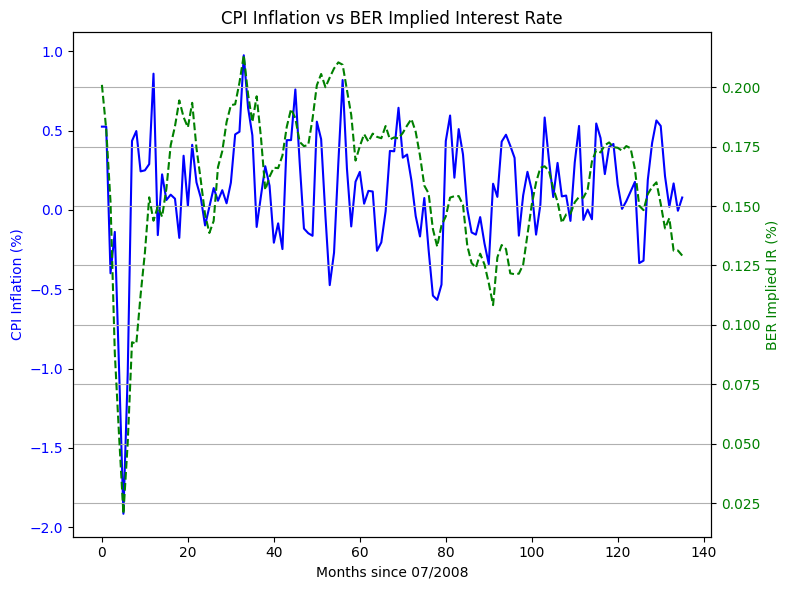

In [ ]:

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot CPI-based inflation on the left y-axis
ax1.plot(df_monthly_cpi['inflation']*100, color='blue', linewidth=1.5, label='CPI Inflation')
ax1.set_ylabel('CPI Inflation (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Months since 07/2008')
# ax1.set_xticks(df_monthly_cpi['YearMonth'][::12])  # Optional: show every 12th label
# ax1.set_xticklabels(df_monthly_cpi['YearMonth'][::12], rotation=45)

# Create right y-axis
ax2 = ax1.twinx()
ax2.plot(ber_monthly['IR_ber'], color='green', linestyle='--', label='BER Implied IR')
ax2.set_ylabel('BER Implied IR (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('CPI Inflation vs BER Implied Interest Rate')
fig.tight_layout()
plt.grid(True)
plt.show()


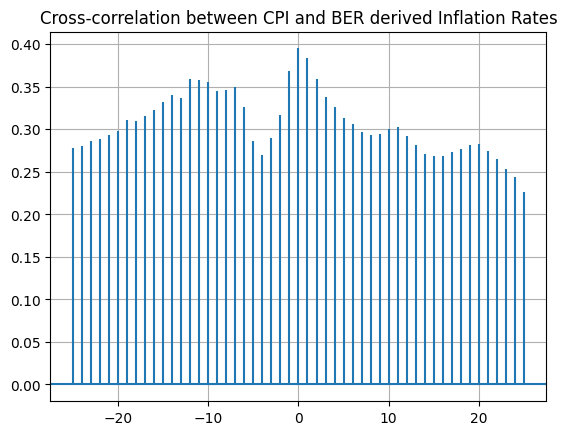

In [ ]:
from statsmodels.tsa.stattools import ccf
plt.xcorr(ber_monthly.IR_ber,df_monthly_cpi.inflation, maxlags = 25)
plt.title('Cross-correlation between CPI and BER derived Inflation Rates')
plt.grid()
plt.show()

In [ ]:
y = df_monthly_cpi['log_inflation']
X = np.array(df_monthly_cpi.index).reshape(-1, 1)

In [ ]:
# Fit linear regression model

X_train = np.array(cpi_ir_train.index).reshape(-1, 1)
y_train = cpi_ir_train['log_inflation'].copy()
X_test = np.array(cpi_ir_test.index).reshape(-1, 1)
y_test = cpi_ir_test['log_inflation'].copy()

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
# ber_lin_reg.fit(X, y)

# Get slope (m) and intercept (b)
m = lin_reg.coef_[0]
b = lin_reg.intercept_

print(f"m = {m}, b = {b}")

m = 4.62679093943091e-05, b = -0.00027238895060290665


In [ ]:
lin_reg.coef_

array([4.62679094e-05])

In [ ]:
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [ ]:
y_pred = lin_reg.predict(X)

In [ ]:
cpi_ir_train['residuals'] = cpi_ir_train['log_inflation'] - lin_reg.predict(X_train)

In [ ]:
y_train.diff()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0          NaN
1     0.000000
2    -0.009237
3     0.002617
4    -0.008769
        ...   
57   -0.005545
58   -0.003651
59    0.002819
60    0.000618
61   -0.002003
Name: log_inflation, Length: 62, dtype: float64

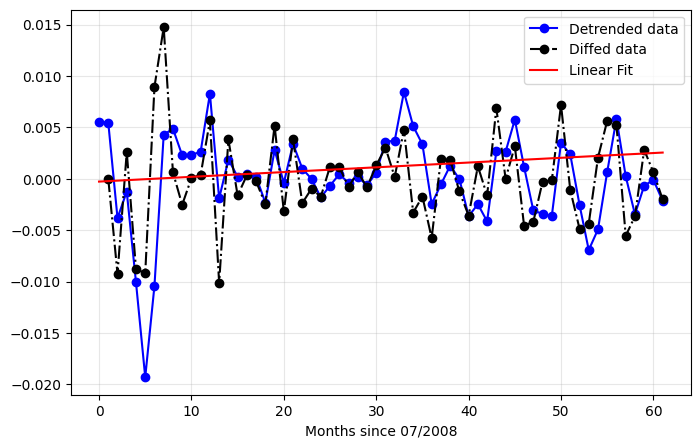

In [ ]:
plt.figure(figsize=(8, 5))

# Plot actual vs predicted values
plt.plot(y_train -y_pred_train, label="Detrended data",marker='o', color="blue", linestyle="-")
plt.plot(y_train.diff(), label="Diffed data",marker='o', color="black", linestyle="-.")

plt.plot(y_pred_train, label="Linear Fit ", color="red", linestyle="-")

# plt.plot(y_test -y_ber_pred_test, label="Detrended data",marker='o', color="red", linestyle="-")
# plt.plot(y - y_ber_pred.ravel(), label="Detrended data",marker='o', color="red", linestyle="-")

# plt.plot(y_ber_pred_train, label="Predicted", color="red", linestyle="--")
# plt.plot(y_test, label="Actual", color="blue", linestyle="-")
# plt.plot(y_ber_pred_test, label="Predicted", color="black"", linestyle="--")
# Labels and title
plt.xlabel("Months since 07/2008")
# plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [ ]:

# Model Evaluation
rmse_ber = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE: {rmse_ber:.4f}")

# Model Evaluation
mape_ber = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MAPE: {mape_ber:.4f}")


RMSE: 0.0041
MAPE: 9.2244


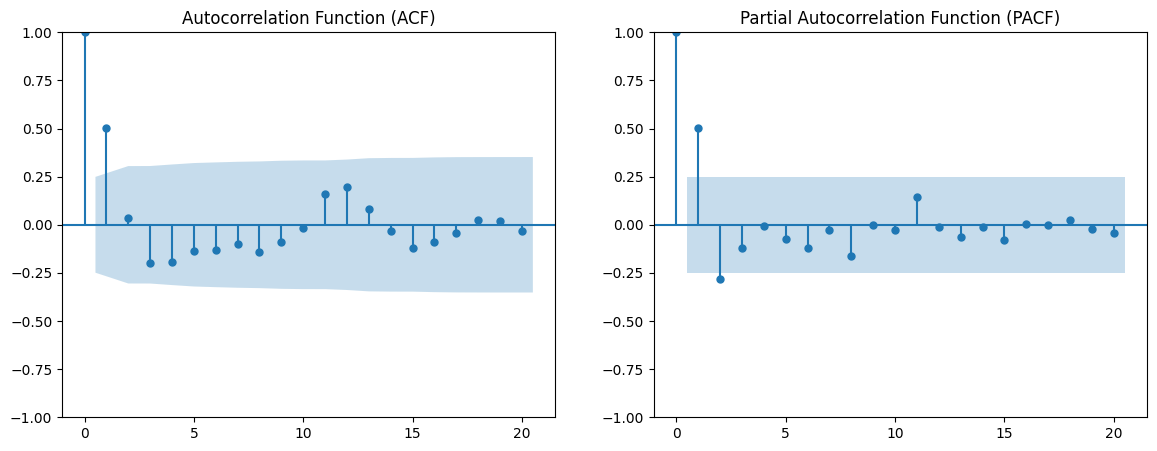

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(cpi_ir_train['residuals'], ax=axes[0], lags=20)
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(cpi_ir_train['residuals'], ax=axes[1], lags=20, method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

AR(0) Training RMSE: 0.004464
AR(1) Training RMSE: 0.003828
AR(2) Training RMSE: 0.003683
AR(3) Training RMSE: 0.003602


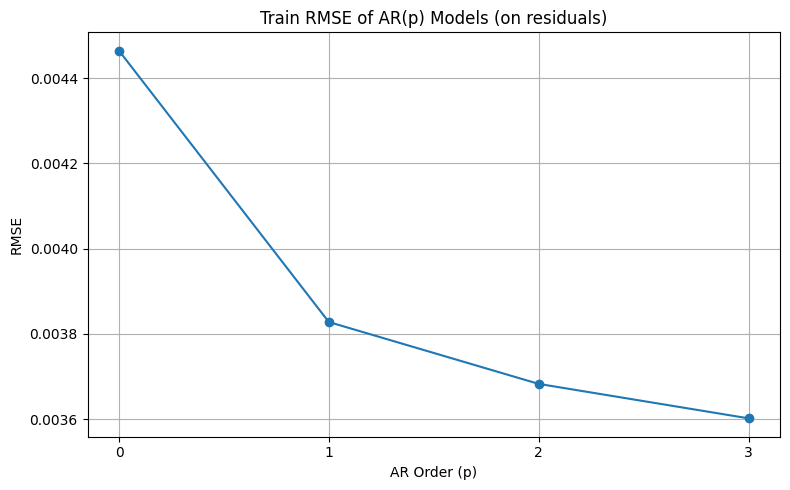

In [ ]:
import matplotlib.pyplot as plt

# Assuming rmse_train_results is already populated from the previous code
# If not, you can run this snippet after the loop
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_train_results = {}
mape_train_results = {}


for p in range(0, 4):
    ar_model = AutoReg(cpi_ir_train['residuals'], lags=p, old_names=False).fit()

    # Predict in-sample (training set)
    predictions = ar_model.predict(start=p, end=len(cpi_ir_train)-1)

    # Actual values corresponding to prediction range
    actual = cpi_ir_train['residuals'].iloc[p:]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    rmse_train_results[p] = rmse

    mape = mean_absolute_percentage_error(actual, predictions)
    mape_train_results[p] = mape
    print(f"AR({p}) Training RMSE: {rmse:.6f}")
    # print(f"AR({p}) Training MAPE: {mape:.6f}")


# Plot RMSEs
plt.figure(figsize=(8, 5))
plt.plot(list(rmse_train_results.keys()), list(rmse_train_results.values()), marker='o', linestyle='-')
plt.title("Train RMSE of AR(p) Models (on residuals)")
plt.xlabel("AR Order (p)")
plt.ylabel("RMSE")
plt.xticks([0, 1, 2, 3])
plt.grid(True)
plt.tight_layout()
plt.show()


AR(0) Training RMSE: 0.004464, AIC: -491.101
AR(1) Training RMSE: 0.003828, AIC: -499.873
AR(2) Training RMSE: 0.003683, AIC: -494.214
AR(3) Training RMSE: 0.003602, AIC: -486.461


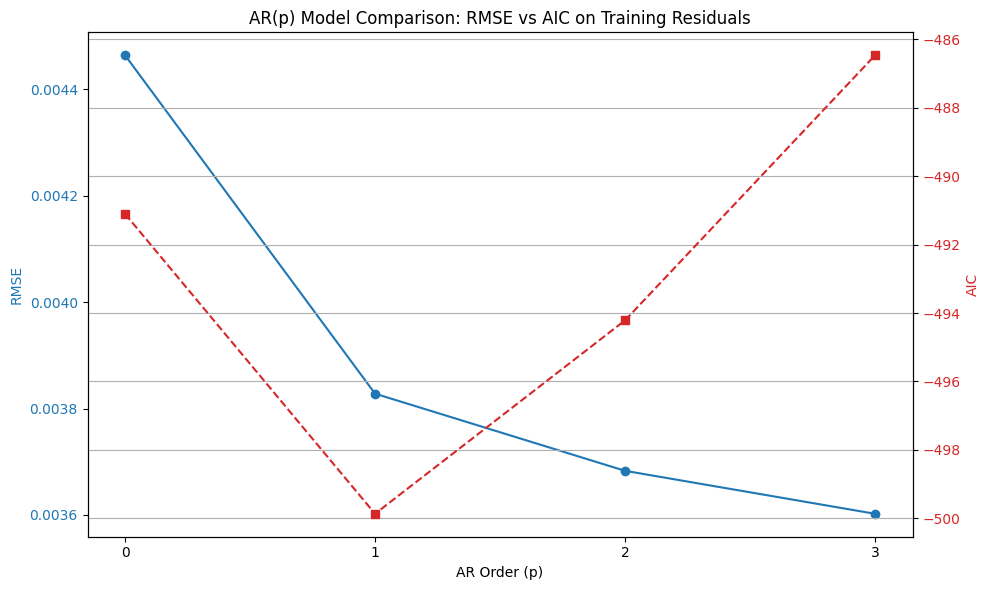

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse_train_results = {}
aic_train_results = {}
mape_train_results = {}

# Fit AR(p) models and collect RMSE, AIC
for p in range(0, 4):
    ar_model = AutoReg(cpi_ir_train['residuals'], lags=p, old_names=False).fit()

    # Predict in-sample (training set)
    predictions = ar_model.predict(start=p, end=len(cpi_ir_train)-1)

    # Actual values corresponding to prediction range
    actual = cpi_ir_train['residuals'].iloc[p:]

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    rmse_train_results[p] = rmse

    # Compute MAPE (optional)
    mape = mean_absolute_percentage_error(actual, predictions)
    mape_train_results[p] = mape

    # Store AIC
    aic_train_results[p] = ar_model.aic

    print(f"AR({p}) Training RMSE: {rmse:.6f}, AIC: {ar_model.aic:.3f}")

# ---------- Plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("AR Order (p)")
ax1.set_ylabel("RMSE", color=color)
ax1.plot(list(rmse_train_results.keys()), list(rmse_train_results.values()),
         marker='o', color=color, label="RMSE")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([0, 1, 2, 3])

# Second y-axis for AIC
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("AIC", color=color)
ax2.plot(list(aic_train_results.keys()), list(aic_train_results.values()),
         marker='s', color=color, linestyle='--', label="AIC")
ax2.tick_params(axis='y', labelcolor=color)

# Title and grid
plt.title("AR(p) Model Comparison: RMSE vs AIC on Training Residuals")
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
#residuals? diff?

AR(2) Coefficients:
const          -0.000137
residuals.L1    0.634077
residuals.L2   -0.280571
dtype: float64


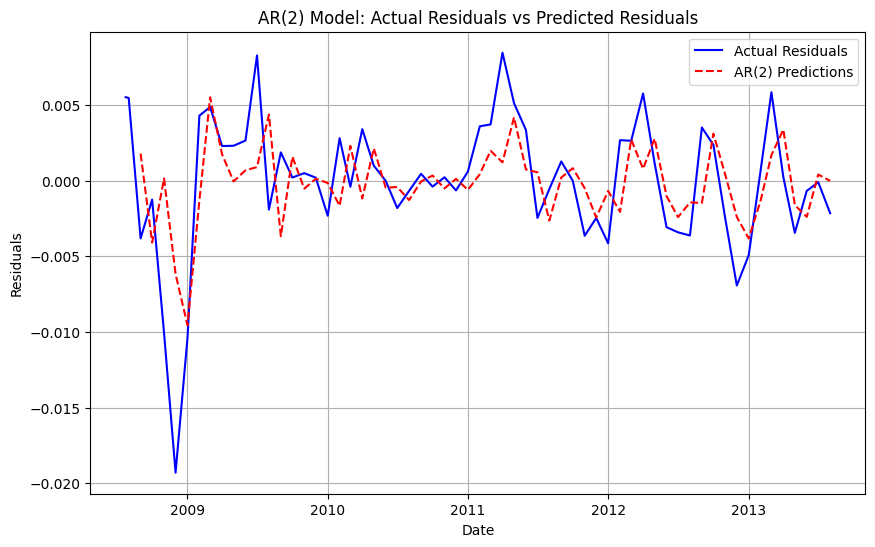

Root Mean Squared Prediction Error (1-Month-Ahead Forecasts): 0.0025061795815492166


<ipython-input-123-5acdf14c2b7e>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cpi_intercept = coef[0]
<ipython-input-123-5acdf14c2b7e>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cpi_lag1_coef = coef[1]
<ipython-input-123-5acdf14c2b7e>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cpi_lag2_coef = coef[2]


In [ ]:
# Fit the AR(2) model
ar_ir_model = AutoReg(cpi_ir_train['residuals'], lags=2).fit()

# Report the coefficients (AR terms and constant)
ar_ir_coefficients = ar_ir_model.params
print(f"AR(2) Coefficients:\n{ar_ir_coefficients}")



# Predict the residuals using the fitted AR model
predictions = ar_ir_model.predict(start=0, end=len(cpi_ir_train)-1)

# Plot the actual residuals and AR model predictions
plt.figure(figsize=(10, 6))
plt.plot(cpi_ir_train['date'], cpi_ir_train['residuals'], label="Actual Residuals", color='blue')
plt.plot(cpi_ir_train['date'], predictions, label="AR(2) Predictions", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("AR(2) Model: Actual Residuals vs Predicted Residuals")
plt.legend()
plt.grid()
plt.show()

# Given AR(2) coefficients
coef = ar_ir_model.params
coef
cpi_intercept = coef[0]
cpi_lag1_coef = coef[1]
cpi_lag2_coef = coef[2]

def one_month_ahead_forecast(train_df, test_df):
    predictions = []
    actuals = []

    # Initialize past values with training data
    train_residuals = train_df['log_inflation'] #- trend_model.predict(train_df.index.values.reshape(-1, 1))
    past_residuals = train_residuals.iloc[-2:].tolist()  # Last two residuals

    test_df = test_df.copy()  # Ensure test_df is not modified in place
    test_df['log_inflation_pred'] = np.nan  # Initialize prediction column

    for i in range(len(test_df)):
        test_index = test_df.index[i]

        # Predict the linear trend for the test month
        # trend_pred = trend_model.predict(np.array([[test_index]]))[0]

        # Apply AR(2) to predict the residual
        ar_pred = (cpi_lag1_coef * past_residuals[-1]) + (cpi_lag2_coef * past_residuals[-2]) + cpi_intercept

        # Compute final prediction
        final_pred =  ar_pred #+ trend_pred

        # Store the prediction in the corresponding row
        test_df.loc[test_index, 'log_inflation_pred'] = final_pred

        # Store predictions and actual values
        predictions.append(final_pred)
        actuals.append(test_df.iloc[i]['log_inflation'])

        # Update past residuals for next month
        new_residual = test_df.iloc[i]['log_inflation'] #- trend_pred  # Compute actual residual
        past_residuals.append(new_residual)
        past_residuals.pop(0)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse, test_df


# Compute RMSE
rmse_1_month_ahead, test_df = one_month_ahead_forecast(cpi_ir_train, cpi_ir_test)
print(f"Root Mean Squared Prediction Error (1-Month-Ahead Forecasts): {rmse_1_month_ahead}")

In [ ]:
test_df

,YearMonth,date,CPI,inflation,log_inflation,log_inflation_pred
62,2013-09,2013-09-01,106.8835,0.001203,0.001202,0.001122
63,2013-10,2013-10-01,107.0078,0.001163,0.001162,0.002226
64,2013-11,2013-11-01,106.7322,-0.002576,-0.002579,0.002004
65,2013-12,2013-12-01,106.5142,-0.002042,-0.002045,-0.000327
66,2014-01,2014-01-01,106.5051,-0.000085,-0.000085,0.001092
...,...,...,...,...,...,...
131,2019-06,2019-06-01,117.0359,0.002129,0.002126,0.005379
132,2019-07,2019-07-01,117.0592,0.000199,0.000199,0.003505
133,2019-08,2019-08-01,117.2548,0.001671,0.001670,0.003198
134,2019-09,2019-09-01,117.2488,-0.000051,-0.000051,0.004701


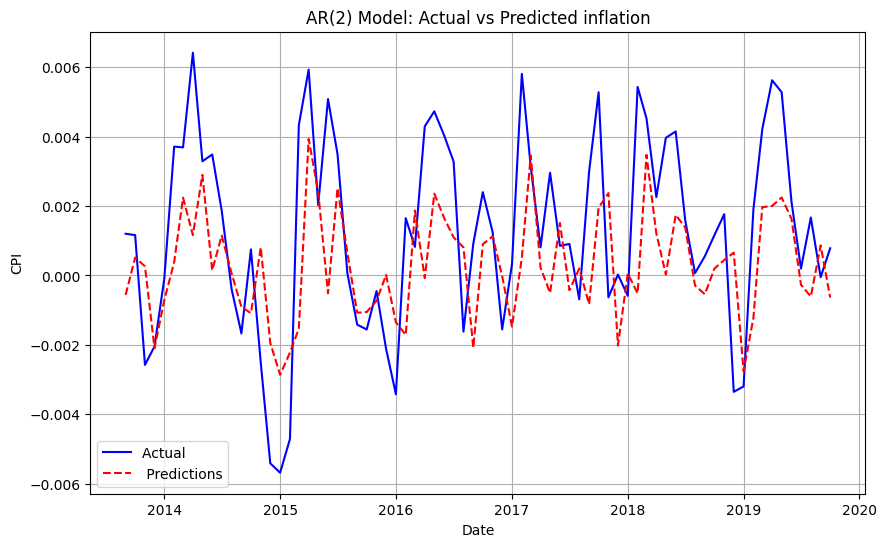

In [ ]:
# Plot the actual residuals and AR model predictions
plt.figure(figsize=(10, 6))
plt.plot(test_df['date'], test_df['log_inflation'], label="Actual ", color='blue')
plt.plot(test_df['date'], test_df['log_inflation_pred'], label=" Predictions", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid()
plt.title("AR(2) Model: Actual vs Predicted inflation")
plt.legend()
plt.show()


--- AR(0) Model ---
RMSE (1-month-ahead forecast): 0.003081
MAPE (1-month-ahead forecast): 1.000000

--- AR(1) Model ---
RMSE (1-month-ahead forecast): 0.002491
MAPE (1-month-ahead forecast): 1.990484

--- AR(2) Model ---
RMSE (1-month-ahead forecast): 0.002506
MAPE (1-month-ahead forecast): 2.625473

--- AR(3) Model ---
RMSE (1-month-ahead forecast): 0.002499
MAPE (1-month-ahead forecast): 2.531805


<ipython-input-121-5f86fad92ba3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coef[0]
<ipython-input-121-5f86fad92ba3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coef[0]
<ipython-input-121-5f86fad92ba3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coef[0]
<ipython-input-121-5f86fad92ba3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ve

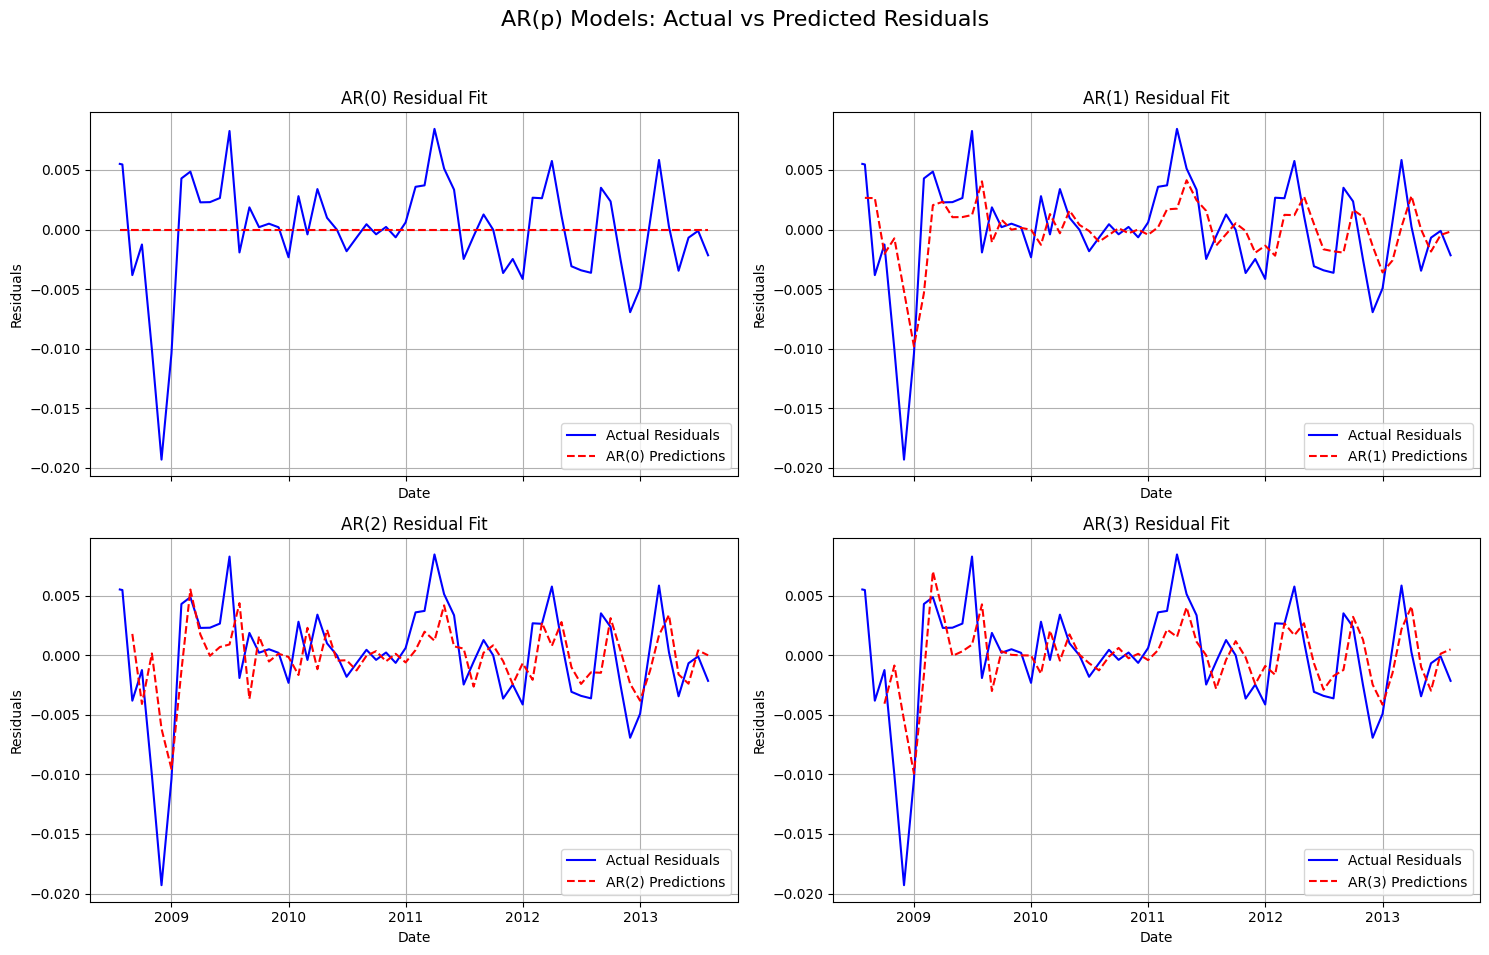

In [ ]:
rmse_results = {}
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axs = axs.flatten()  # Flatten to 1D array for easy iteration

for p in range(0, 4):
    print(f"\n--- AR({p}) Model ---")

    # Fit AR(p) model
    ar_model = AutoReg(cpi_ir_train['residuals'], lags=p, old_names=False).fit()

    # Predict in-sample residuals
    ar_predictions = ar_model.predict(start=0, end=len(cpi_ir_train) - 1)

    # Plot in corresponding subplot
    ax = axs[p]
    ax.plot(cpi_ir_train['date'], cpi_ir_train['residuals'], label="Actual Residuals", color='blue')
    ax.plot(cpi_ir_train['date'], ar_predictions, label=f"AR({p}) Predictions", color='red', linestyle='--')
    ax.set_title(f"AR({p}) Residual Fit")
    ax.set_xlabel("Date")
    ax.set_ylabel("Residuals")
    ax.grid(True)
    ax.legend()

    # Forecasting function setup
    coef = ar_model.params
    intercept = coef[0]
    lags_coefs = coef[1:].tolist()

    def one_month_forecast_with_ar_p(train_df, test_df,  lags_coefs, intercept):
        predictions = []
        actuals = []

        past_residuals = train_df['log_inflation'].iloc[-len(lags_coefs):].tolist()# - trend_model.predict(train_df.index.values.reshape(-1, 1))).iloc[-len(lags_coefs):].tolist()
        test_df = test_df.copy()
        test_df['log_inflation_pred'] = np.nan

        for i in range(len(test_df)):
            test_index = test_df.index[i]
            # trend_pred = trend_model.predict(np.array([[test_index]]))[0]
            ar_pred = intercept + sum([c * r for c, r in zip(lags_coefs, reversed(past_residuals))])
            final_pred =  ar_pred #trend_pred +
            test_df.loc[test_index, 'log_inflation_pred'] = final_pred
            predictions.append(final_pred)
            actuals.append(test_df.iloc[i]['log_inflation'])
            new_residual = test_df.iloc[i]['log_inflation'] #- trend_pred
            past_residuals.append(new_residual)
            if len(past_residuals) > len(lags_coefs):
                past_residuals.pop(0)

        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mape = mean_absolute_percentage_error(actuals, predictions)
        return mape, rmse, test_df

    # Calculate RMSE
    mape, rmse, _ = one_month_forecast_with_ar_p(cpi_ir_train, cpi_ir_test,  lags_coefs, intercept)
    rmse_results[p] = rmse
    print(f"RMSE (1-month-ahead forecast): {rmse:.6f}")
    print(f"MAPE (1-month-ahead forecast): {mape:.6f}")

# Tidy subplot layout
plt.suptitle("AR(p) Models: Actual vs Predicted Residuals", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Best AR(p): 1 with RMSE = 0.002491
Best model with p=1 and params:
 const          -0.000108
residuals.L1    0.502559
dtype: float64
Validation RMSE = 0.002491
Validation MAPE = 1.990484


<ipython-input-124-1b4f4bca4bd7>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coef[0]


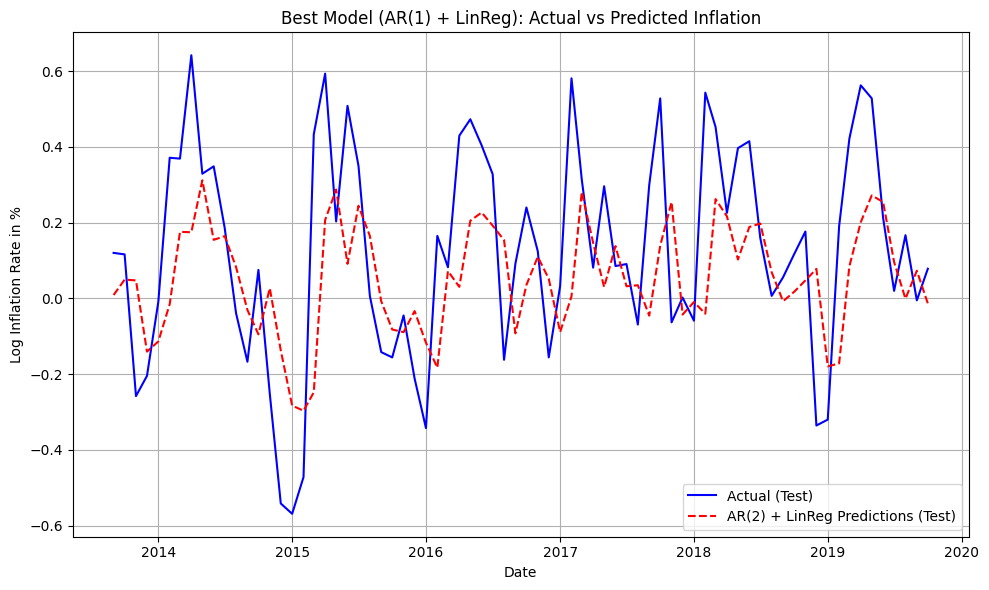

In [ ]:

# Identify best AR(p)
best_p = min(rmse_results, key=rmse_results.get)
print(f"Best AR(p): {best_p} with RMSE = {rmse_results[best_p]:.6f}")

# Refit best AR(p) model
best_ar_model = AutoReg(cpi_ir_train['residuals'], lags=best_p, old_names=False).fit()

# Get coefficients
coef = best_ar_model.params
intercept = coef[0]
lags_coefs = coef[1:].tolist()
print(f'Best model with p={best_p} and params:\n {best_ar_model.params}')
# Forecast with best model
mape_test,rmse_test, best_test_df = one_month_forecast_with_ar_p(cpi_ir_train, cpi_ir_test, lags_coefs, intercept)
print(f"Validation RMSE = {rmse_test:.6f}")
print(f"Validation MAPE = {mape_test:.6f}")


# Plot actual vs predicted log_inflation
plt.figure(figsize=(10, 6))
plt.plot(best_test_df['date'], best_test_df['log_inflation']*100, label="Actual (Test)", color='blue')
plt.plot(best_test_df['date'], best_test_df['log_inflation_pred']*100, label=f"AR({2}) + LinReg Predictions (Test)", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Log Inflation Rate in %")
plt.title(f"Best Model (AR({best_p})): Actual vs Predicted Inflation")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Train RMSE = 0.003932


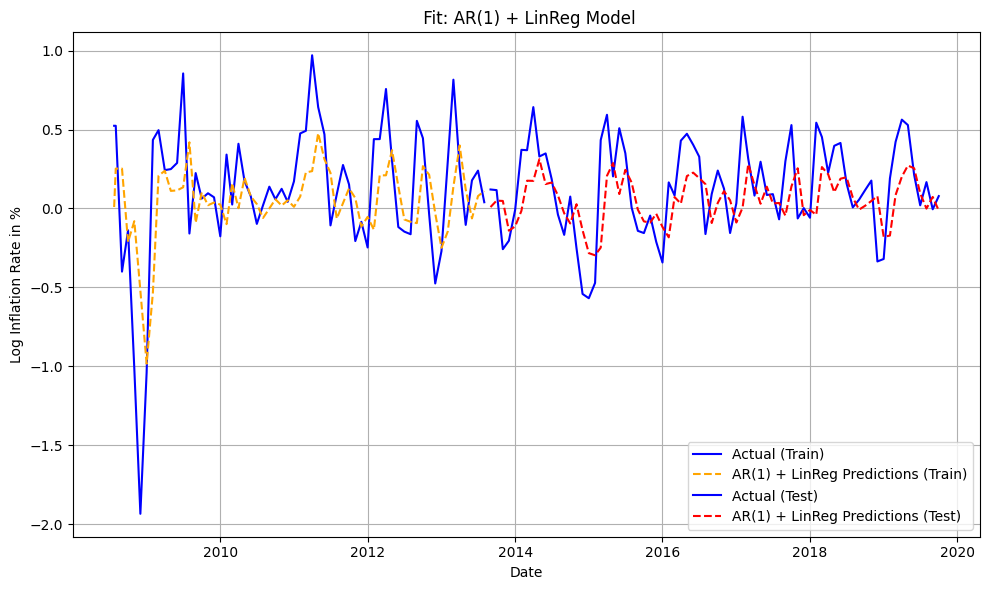

In [ ]:
# Forecast on the train set using best AR(p) + LinReg model
mape_train, rmse_train, best_train_df = one_month_forecast_with_ar_p(cpi_ir_train, cpi_ir_train,  lags_coefs, intercept)
print(f"Train RMSE = {rmse_train:.6f}")

# Plot actual vs predicted log_inflation on train set
plt.figure(figsize=(10, 6))
plt.plot(best_train_df['date'], best_train_df['log_inflation']*100, label="Actual (Train)", color='blue')
plt.plot(best_train_df['date'], best_train_df['log_inflation_pred']*100, label=f"AR({best_p}) + LinReg Predictions (Train)", color='orange', linestyle='--')
plt.plot(best_test_df['date'], best_test_df['log_inflation']*100, label="Actual (Test)", color='blue')
plt.plot(best_test_df['date'], best_test_df['log_inflation_pred']*100, label=f"AR({best_p}) + LinReg Predictions (Test)", color='red', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Log Inflation Rate in %")
plt.title(f" Fit: AR({best_p}) Model")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


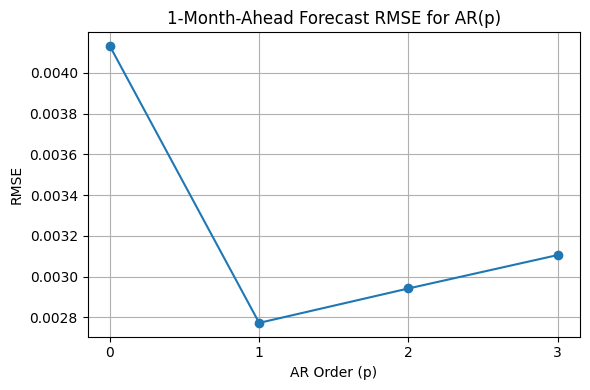

In [ ]:

plt.figure(figsize=(6, 4))
plt.plot(list(rmse_results.keys()), list(rmse_results.values()), marker='o', linestyle='-')
plt.xlabel('AR Order (p)')
plt.ylabel('RMSE')
plt.title('1-Month-Ahead Forecast RMSE for AR(p)')
plt.grid(True)
plt.xticks([0, 1, 2, 3])
plt.tight_layout()
plt.show()

In [ ]:
ber_monthly

,YearMonth,BER,IR_ber
0,2008-07,2.438636,0.200983
1,2008-08,2.209524,0.182288
2,2008-09,1.836190,0.151743
3,2008-10,1.061818,0.088057
4,2008-11,0.638333,0.053039
...,...,...,...
131,2019-06,1.700000,0.140575
132,2019-07,1.752727,0.144900
133,2019-08,1.586364,0.131245
134,2019-09,1.587000,0.131298


In [ ]:
ber

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,DATE,T10YIE,YearMonth
1433,2008-07-01,2.52,2008-07
1434,2008-07-02,2.56,2008-07
1435,2008-07-03,2.57,2008-07
1436,2008-07-04,NaN,2008-07
1437,2008-07-07,2.52,2008-07
...,...,...,...
4388,2019-10-29,1.61,2019-10
4389,2019-10-30,1.57,2019-10
4390,2019-10-31,1.54,2019-10
4391,2019-11-01,1.59,2019-11


In [ ]:
ber['IR_ber'] = ((ber.T10YIE.values/100+1)**(1/12)-1)*100


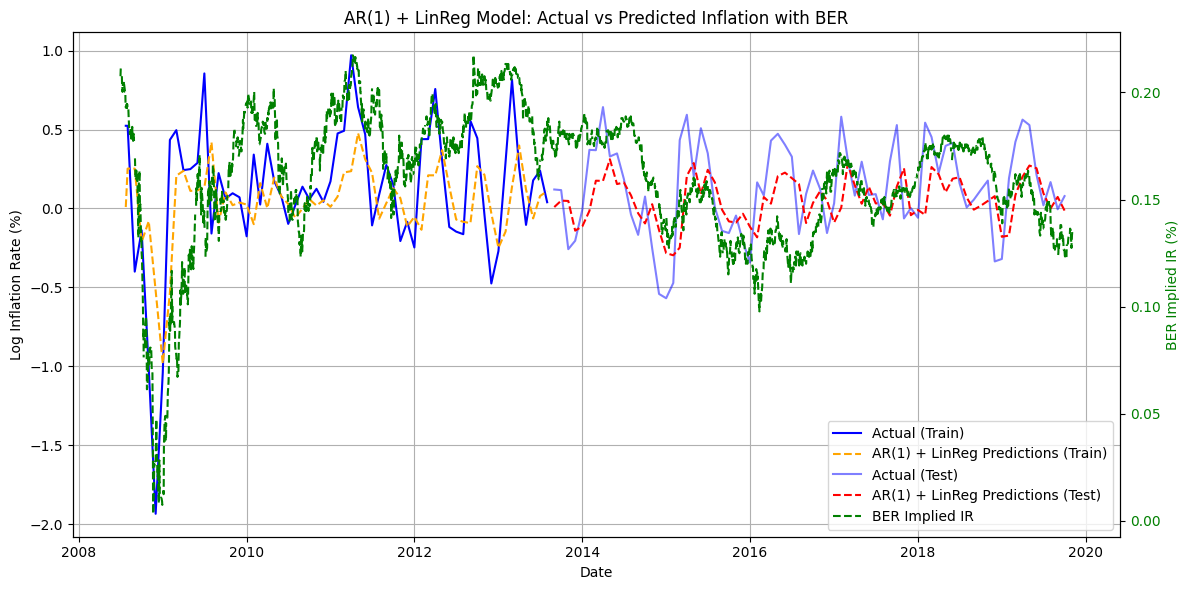

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis (Left) for inflation
ax1.plot(best_train_df['date'], best_train_df['log_inflation']*100, label="Actual (Train)", color='blue')
ax1.plot(best_train_df['date'], best_train_df['log_inflation_pred']*100, label=f"AR({best_p}) + LinReg Predictions (Train)", color='orange', linestyle='--')
ax1.plot(best_test_df['date'], best_test_df['log_inflation']*100, label="Actual (Test)", color='blue', alpha=0.5)
ax1.plot(best_test_df['date'], best_test_df['log_inflation_pred']*100, label=f"AR({best_p}) + LinReg Predictions (Test)", color='red', linestyle='--')

ax1.set_xlabel("Date")
ax1.set_ylabel("Log Inflation Rate (%)")
ax1.grid(True)

# Create secondary y-axis (Right) for BER Implied IR
ax2 = ax1.twinx()
ax2.plot(ber['DATE'], ber['IR_ber'], color='green', linestyle='--', label='BER Implied IR')
ax2.set_ylabel("BER Implied IR (%)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title(f"AR({best_p}) + LinReg Model: Actual vs Predicted Inflation with BER")
plt.tight_layout()
plt.show()


## SARIMAX

In [ ]:
ber_ir_train

,YearMonth,BER,IR_ber
0,2008-07,2.438636,0.200983
1,2008-08,2.209524,0.182288
2,2008-09,1.836190,0.151743
3,2008-10,1.061818,0.088057
4,2008-11,0.638333,0.053039
...,...,...,...
57,2013-04,2.411364,0.198760
58,2013-05,2.283182,0.188303
59,2013-06,2.048500,0.169126
60,2013-07,2.122273,0.175159


In [ ]:
cpi_ir_train

,YearMonth,date,CPI,inflation,log_inflation,residuals
0,2008-07,2008-07-24,100.00000,0.005251,0.005237,0.005510
1,2008-08,2008-08-01,100.52510,0.005251,0.005237,0.005463
2,2008-09,2008-09-01,100.12380,-0.003992,-0.004000,-0.003820
3,2008-10,2008-10-01,99.98538,-0.001382,-0.001383,-0.001250
4,2008-11,2008-11-01,98.97539,-0.010101,-0.010153,-0.010065
...,...,...,...,...,...,...
57,2013-04,2013-04-01,106.37890,0.002614,0.002611,0.000246
58,2013-05,2013-05-01,106.26830,-0.001040,-0.001040,-0.003451
59,2013-06,2013-06-01,106.45750,0.001780,0.001779,-0.000679
60,2013-07,2013-07-01,106.71300,0.002400,0.002397,-0.000107


In [ ]:
ber_ir_train.isna().sum()

YearMonth    0
BER          0
IR_ber       0
dtype: int64

                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   62
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 253.830
Date:                Thu, 17 Apr 2025   AIC                           -501.659
Time:                        14:48:10   BIC                           -495.326
Sample:                             0   HQIC                          -499.177
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0109      0.007      1.617      0.106      -0.002       0.024
ar.L1          0.4976      0.082      6.054      0.000       0.337       0.659
sigma2      1.419e-05   1.98e-06      7.181      0.0

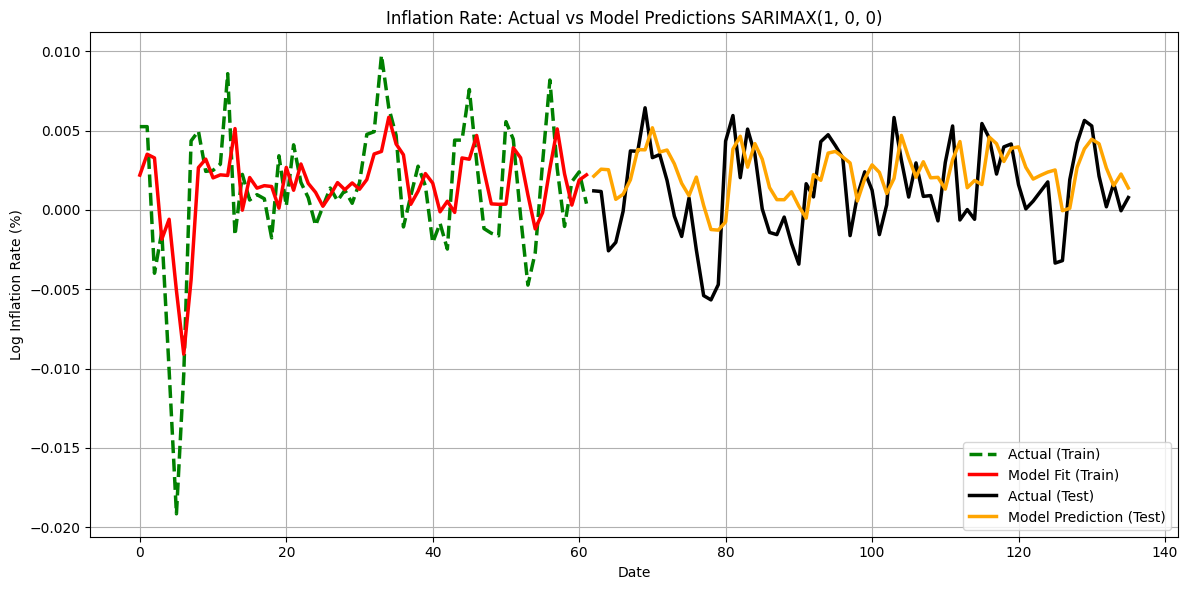

In [ ]:
exogenous = ber_ir_train.copy().drop(['BER', 'YearMonth'], axis=1).values

# Prepare endogenous (Inflation)
endogenous = cpi_ir_train['inflation'].reset_index(drop=True)

# Fit SARIMAX(1,0,0) with exogenous
model_external = sm.tsa.statespace.SARIMAX(endogenous, exog=exogenous, order=(1, 0, 0), enforce_stationarity=False)
model_external = model_external.fit(disp=False)

print(model_external.summary())

# Predict on training data
training_predictions3 = model_external.predict(start=0, end=len(endogenous)-1, exog=exogenous)

# Manual test prediction
coef = model_external.params
phi = coef['ar.L1']
beta = coef['x1']

k = 1
past = [endogenous.iloc[-k]]
test_predictions3 = []

# First test prediction
pred = phi * past[0] + beta * ber_ir_test['IR_ber'].iloc[0]
test_predictions3.append(pred)
past.append(cpi_ir_test['inflation'].iloc[0])

# Loop through remaining test points
for t in range(1, len(cpi_ir_test)):
    lag = past[-k:]
    pred = phi * lag[0] + beta * ber_ir_test['IR_ber'].iloc[t]
    test_predictions3.append(pred)
    past.append(cpi_ir_test['inflation'].iloc[t])

# Evaluation metrics
true_values = cpi_ir_test['inflation'].values
rmse = mean_squared_error(true_values, test_predictions3) ** 0.5
mape = mean_absolute_percentage_error(true_values, test_predictions3)

print(f"✅ RMSE: {rmse}")
print(f"✅ MAPE: {mape * 100:.2f}%")

# === Plotting ===
plt.figure(figsize=(12, 6))

# Plot training actual CPI
plt.plot(cpi_ir_train.index, endogenous, label="Actual (Train)", color="green", linestyle="dashed", linewidth=2.5)

# Plot training predictions
plt.plot(cpi_ir_train.index, training_predictions3, label="Model Fit (Train)", color="red", linewidth=2.5)

# Plot test actual CPI
plt.plot(cpi_ir_test.index, true_values, label="Actual (Test)", color="black", linewidth=2.5)

# Plot test predictions
plt.plot(cpi_ir_test.index, test_predictions3, label="Model Prediction (Test)", color="orange", linewidth=2.5)

# Final touches
plt.xlabel("Date")
plt.ylabel("Log Inflation Rate (%)")
plt.title("Inflation Rate: Actual vs Model Predictions SARIMAX(1, 0, 0)")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   62
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 251.305
Date:                Thu, 17 Apr 2025   AIC                           -494.610
Time:                        14:48:11   BIC                           -486.233
Sample:                             0   HQIC                          -491.334
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0088      0.005      1.671      0.095      -0.002       0.019
ar.L1          0.6194      0.112      5.531      0.000       0.400       0.839
ar.L2         -0.2521      0.115     -2.187      0.0

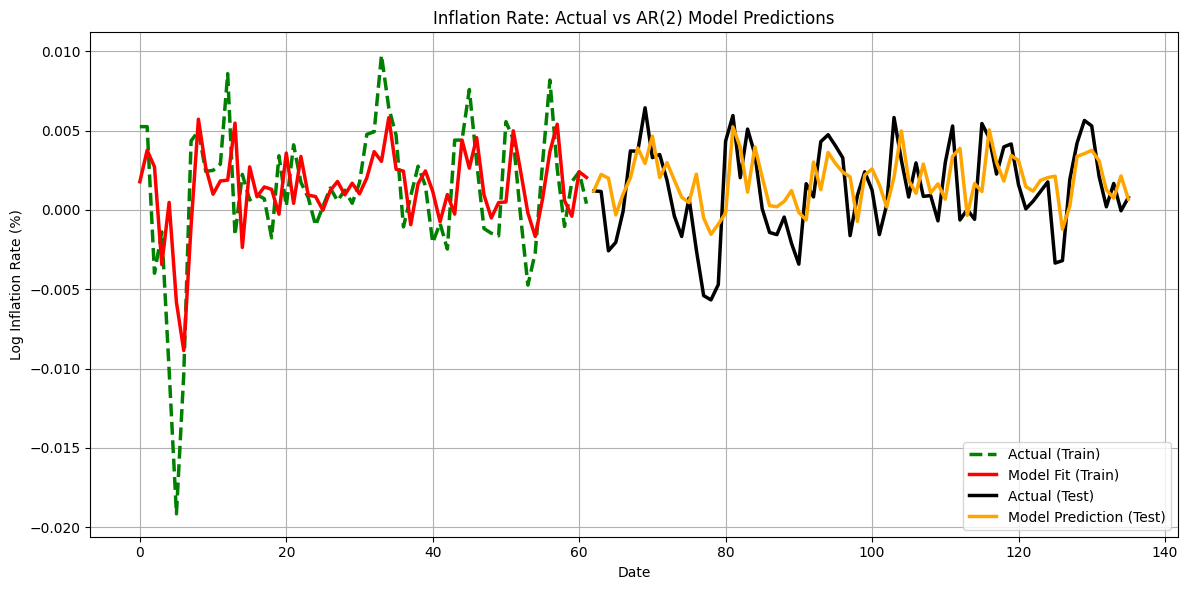

In [ ]:

# --- Prepare training data ---

# Exogenous: Drop 'BER', 'YearMonth', and first 2 rows to match endogenous
exogenous = ber_ir_train.drop(['BER', 'YearMonth'], axis=1).values

# Endogenous: Drop first 2 rows to align with exogenous
endogenous = cpi_ir_train['inflation'].reset_index(drop=True)

# --- Fit AR(2) Model ---
model_external = sm.tsa.statespace.SARIMAX(endogenous, exog=exogenous, order=(2, 0, 0), enforce_stationarity=False)
model_external = model_external.fit(disp=False)

print(model_external.summary())

# --- In-sample prediction (Train) ---
training_predictions3 = model_external.predict(start=0, end=len(endogenous) - 1, exog=exogenous)

# --- Manual Forecast (Test) ---
coef = model_external.params
phi1 = coef.get('ar.L1', 0)
phi2 = coef.get('ar.L2', 0)
beta = coef.get('x1', 0)

k = 2
past = list(endogenous.iloc[-k:])  # Last k values from training
test_predictions3 = []

# First test prediction
pred = phi2 * past[0] + phi1 * past[1] + beta * ber_ir_test['IR_ber'].iloc[0]
test_predictions3.append(pred)
past.append(cpi_ir_test['inflation'].iloc[0])

# Loop through test data
for t in range(1, len(cpi_ir_test)):
    lag = past[-k:]
    pred = phi2 * lag[0] + phi1 * lag[1] + beta * ber_ir_test['IR_ber'].iloc[t]
    test_predictions3.append(pred)
    past.append(cpi_ir_test['inflation'].iloc[t])

# --- Evaluation ---
true_values = cpi_ir_test['inflation'].values
rmse = mean_squared_error(true_values, test_predictions3) ** 0.5
mape = mean_absolute_percentage_error(true_values, test_predictions3)

print(f"✅ RMSE: {rmse}")
print(f"✅ MAPE: {mape * 100:.2f}%")

# --- Plot ---
plt.figure(figsize=(12, 6))

# Plot training actual CPI
plt.plot(cpi_ir_train.index, endogenous, label="Actual (Train)", color="green", linestyle="dashed", linewidth=2.5)

# Plot training predictions
plt.plot(cpi_ir_train.index, training_predictions3, label="Model Fit (Train)", color="red", linewidth=2.5)

# Plot test actual CPI
plt.plot(cpi_ir_test.index, true_values, label="Actual (Test)", color="black", linewidth=2.5)

# Plot test predictions
plt.plot(cpi_ir_test.index, test_predictions3, label="Model Prediction (Test)", color="orange", linewidth=2.5)

# Final touches
plt.xlabel("Date")
plt.ylabel("Log Inflation Rate (%)")
plt.title("Inflation Rate: Actual vs AR(2) Model Predictions")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## with MA(1)

                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   62
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 256.148
Date:                Thu, 17 Apr 2025   AIC                           -502.296
Time:                        14:48:11   BIC                           -491.824
Sample:                             0   HQIC                          -498.200
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0099      0.001      8.051      0.000       0.008       0.012
ar.L1          1.3404      0.089     15.020      0.000       1.165       1.515
ar.L2         -0.5367      0.103     -5.222      0.0

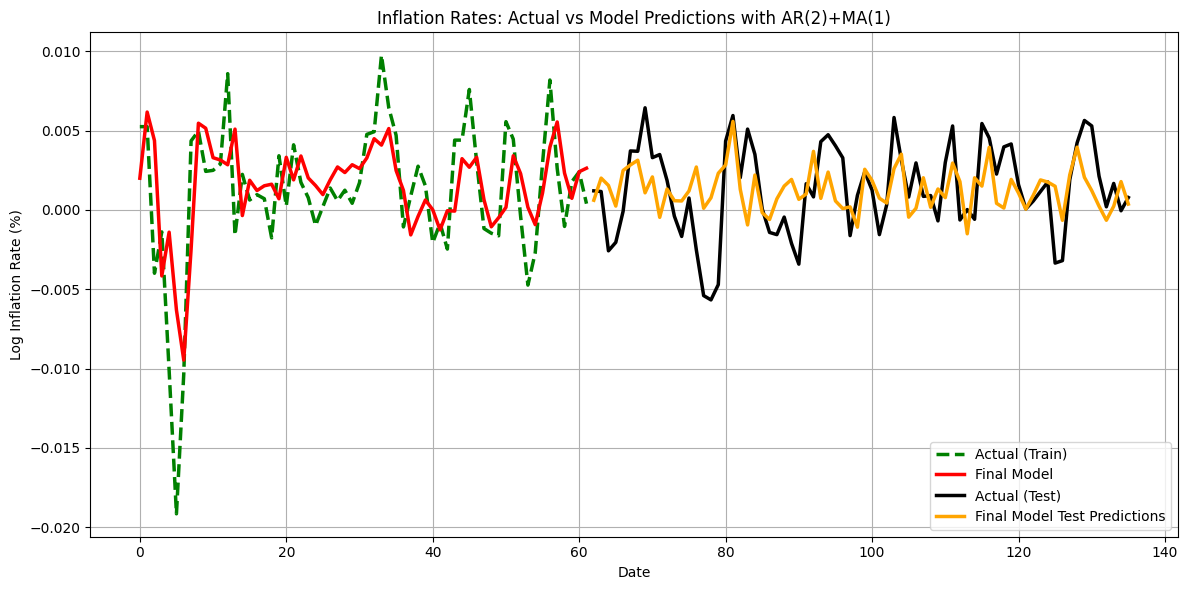

In [ ]:
# Prepare full endogenous and exogenous data from the start
exogenous = ber_ir_train.drop(['BER', 'YearMonth'], axis=1).values
endogenous = cpi_ir_train['inflation'].reset_index(drop=True)

# Fit AR(2) + MA(1) with exogenous regressor
model_external = sm.tsa.statespace.SARIMAX(endogenous, exog=exogenous, order=(2, 0, 1), enforce_stationarity=False)
model_external = model_external.fit(disp=False)

# Get coefficients
coef = model_external.params
print(model_external.summary())

# Training predictions for all of training set
training_predictions4 = model_external.predict(start=0, end=len(endogenous)-1, exog=exogenous)

# Test set prediction using last 2 endogenous values (lagged)
phi1 = coef.get('ar.L1', 0)
phi2 = coef.get('ar.L2', 0)
theta1 = coef.get('ma.L1', 0)
beta = coef.get('x1', 0)

k = 2
past = list(endogenous.iloc[-k:])
test_predictions4 = []

# First test point prediction
pred = phi2 * past[0] + phi1 * past[1] + theta1 * past[1] + beta * ber_ir_test['IR_ber'].iloc[0]
test_predictions4.append(pred)
past.append(cpi_ir_test['inflation'].iloc[0])

# Loop over remaining test points
for t in range(1, len(cpi_ir_test)):
    lag = past[-k:]
    pred = phi2 * lag[0] + phi1 * lag[1] + theta1 * lag[1] + beta * ber_ir_test['IR_ber'].iloc[t]
    test_predictions4.append(pred)
    past.append(cpi_ir_test['inflation'].iloc[t])

# Evaluation
print("The rmse of this final fit is " + str(mean_squared_error(cpi_ir_test.inflation.values[:-2], test_predictions4[:-2])**0.5))
print("The mape of this final fit is " + str(mean_absolute_percentage_error(cpi_ir_test.inflation.values[:-2], test_predictions4[:-2])))


plt.figure(figsize=(12, 6))

# Actual train data
plt.plot(cpi_ir_train.index, cpi_ir_train.inflation,
         label="Actual (Train)", color="green", linestyle="dashed", linewidth=2.5)

# Model fit on training data
plt.plot(cpi_ir_train.index, training_predictions4,
         label="Final Model", color="red", linewidth=2.5)

# Actual test data
plt.plot(cpi_ir_test.index, cpi_ir_test.inflation,
         label="Actual (Test)", color="black", linewidth=2.5)

# Predictions on test data
plt.plot(cpi_ir_test.index[:len(test_predictions4)], test_predictions4,
         label="Final Model Test Predictions", color="orange", linewidth=2.5)

# Formatting
plt.xlabel("Date")
plt.ylabel("Log Inflation Rate (%)")
plt.title("Inflation Rates: Actual vs Model Predictions with AR(2)+MA(1)")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## with MA(2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['coerce_errors']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   62
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 259.982
Date:                Thu, 17 Apr 2025   AIC                           -507.964
Time:                        14:48:12   BIC                           -495.201
Sample:                             0   HQIC                          -502.953
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0101      0.005      2.014      0.044       0.000       0.020
ar.L1          0.1046      0.595      0.176      0.860      -1.061       1.270
ar.L2         -0.4012      0.272     -1.475      0.1

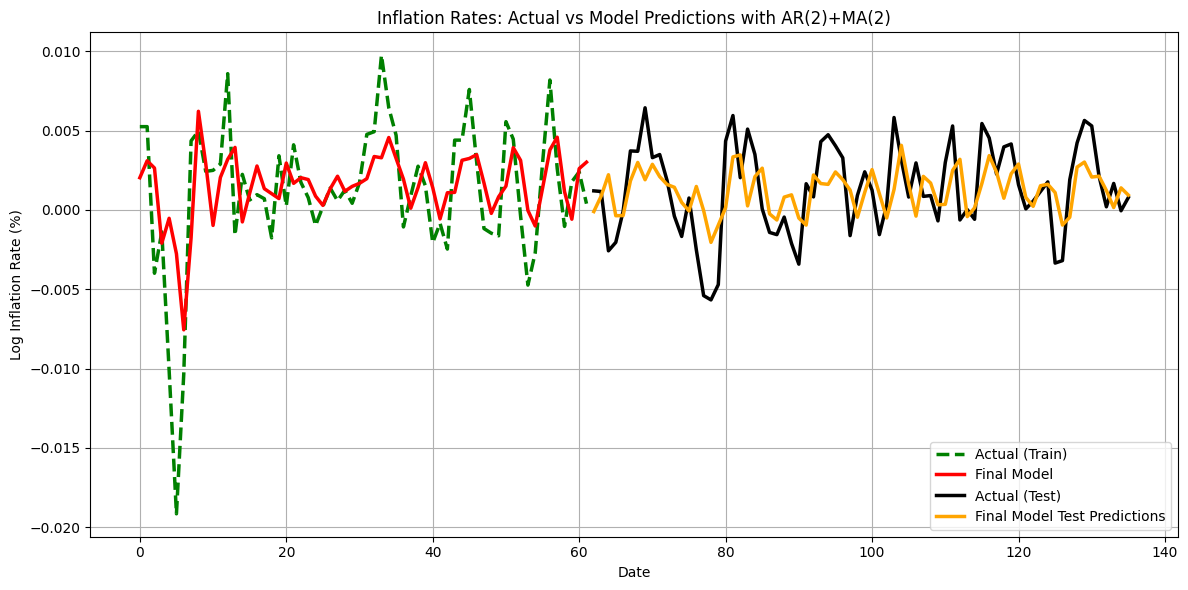

In [ ]:
exogenous = ber_ir_train.copy().drop(['BER'], axis=1)
exogenous = exogenous.drop(['YearMonth'], axis=1).values  # Do not drop rows anymore

endogenous = cpi_ir_train.inflation.reset_index(drop=True)  # Start from index 0
model_external = sm.tsa.statespace.SARIMAX(endogenous, exogenous, order=(2, 0, 2), coerce_errors=True).fit(disp=False)  # AR(2)
coef = model_external.params
print(model_external.summary())

# Predictions from start (index 0)
training_predictions4 = model_external.predict(start=0, end=len(endogenous)-1, exog=exogenous)

k = 2
past = list(endogenous.iloc[-k:].values)

# Get residuals from the training model
residuals_train = model_external.resid

# Get last k residuals
past_resid = list(residuals_train[-k:])

test_predictions4 = []

# --- Predict first test point ---
ar_part = coef['ar.L2']*past[0] + coef['ar.L1']*past[1]
ma_part = coef['ma.L2']*past_resid[0] + coef['ma.L1']*past_resid[1]
exog_part = coef['x1'] * ber_ir_test.IR_ber.iloc[0]

pred = ar_part + ma_part + exog_part
test_predictions4.append(pred)

# Store first residual for future MA terms
obs = cpi_ir_test.inflation.values[0]
resid = obs - pred
past.append(obs)
past_resid.append(resid)

# --- Recursive predictions ---
for t in range(1, len(cpi_ir_test.inflation)):
    ar_part = coef['ar.L2']*past[-2] + coef['ar.L1']*past[-1]
    ma_part = coef['ma.L2']*past_resid[-2] + coef['ma.L1']*past_resid[-1]
    exog_part = coef['x1'] * ber_ir_test.IR_ber.iloc[t]

    pred = ar_part + ma_part + exog_part
    test_predictions4.append(pred)

    obs = cpi_ir_test.inflation.values[t]
    resid = obs - pred

    past.append(obs)
    past_resid.append(resid)

# --- Metrics ---
print("The RMSE of this final fit is", round(mean_squared_error(cpi_ir_test.inflation.values, test_predictions4)**0.5, 4))
print("The MAPE of this final fit is", round(mean_absolute_percentage_error(cpi_ir_test.inflation.values, test_predictions4), 4))

# --- Plot ---
plt.figure(figsize=(12, 6))

plt.plot(endogenous.index, endogenous, label="Actual (Train)", color="green", linestyle="dashed", linewidth=2.5)
plt.plot(endogenous.index, training_predictions4, label="Final Model", color="red", linewidth=2.5)
plt.plot(cpi_ir_test.index, cpi_ir_test.inflation, label="Actual (Test)", color="black", linewidth=2.5)
plt.plot(cpi_ir_test.index[:len(test_predictions4)], test_predictions4, label="Final Model Test Predictions", color="orange", linewidth=2.5)

plt.xlabel("Date")
plt.ylabel("Log Inflation Rate (%)")
plt.title("Inflation Rates: Actual vs Model Predictions with AR(2)+MA(2)")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Starting SARIMAX grid search...

✅ Best Model Found:
Order: (1, 0, 0)
Seasonal Order: (0, 0, 0, 0)
AIC: -501.66
                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   62
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 253.830
Date:                Thu, 17 Apr 2025   AIC                           -501.659
Time:                        15:01:56   BIC                           -495.326
Sample:                             0   HQIC                          -499.177
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IR_ber         0.0109      0.007      1.617      0.106      -0.002       0.024
ar.L1          0.49

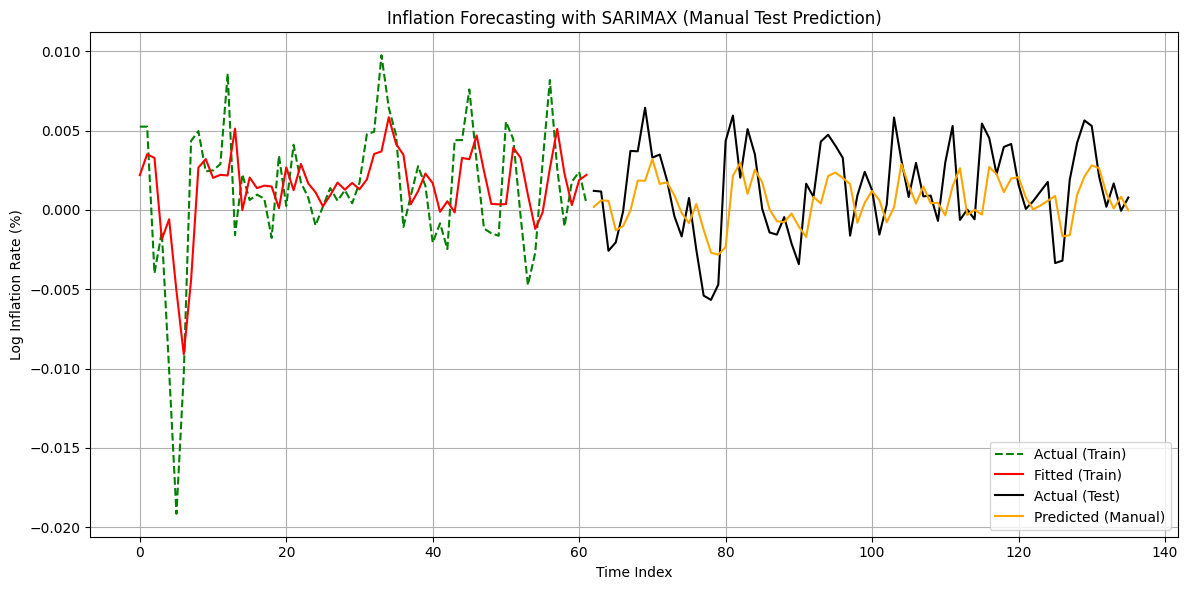

In [ ]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# === Step 1: Prepare exogenous and endogenous data (NO LAGS) ===
exogenous_train = ber_ir_train[['IR_ber']].reset_index(drop=True)
endogenous_train = cpi_ir_train.inflation.reset_index(drop=True)

# === Step 2: Grid search for best SARIMAX ===
p = d = range(0, 3)
P = D = Q = range(0, 2)
q = range(0, 3)  # Only testing MA(2)
seasonal_periods = [0, 4, 6]

order_combinations = list(itertools.product(p, d, q))
seasonal_order_combinations = list(itertools.product(P, D, Q, seasonal_periods))

best_aic = np.inf
best_model = None
best_order = None
best_seasonal = None

print("Starting SARIMAX grid search...")

for order in order_combinations:
    for seasonal_order in seasonal_order_combinations:
        try:
            model = sm.tsa.statespace.SARIMAX(
                endogenous_train,
                exog=exogenous_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                best_order = order
                best_seasonal = seasonal_order
        except Exception as e:
            continue

print("\n✅ Best Model Found:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal}")
print(f"AIC: {best_aic:.2f}")
print(best_model.summary())

# === Step 3: Manual Test Prediction using Model Coefficients ===
coef = best_model.params
p_order = best_order[0]  # AR order
q_order = best_order[2]  # MA order

# Prepare exogenous and endogenous test data
exog_test_series = ber_ir_test.IR_ber.reset_index(drop=True)
true_test_values = cpi_ir_test.inflation.reset_index(drop=True)

# Initialize past observations and errors
past_obs = list(endogenous_train[-p_order:]) if p_order > 0 else []
residuals_train = best_model.resid
past_errors = list(residuals_train[-q_order:]) if q_order > 0 else []

test_preds = []

for t in range(len(true_test_values)):
    # AR part
    ar_sum = sum(
        coef.get(f'ar.L{i+1}', 0) * past_obs[-(i+1)]
        for i in range(p_order)
    ) if p_order > 0 else 0

    # MA part
    ma_sum = sum(
        coef.get(f'ma.L{i+1}', 0) * past_errors[-(i+1)]
        for i in range(q_order)
    ) if q_order > 0 else 0

    # Exogenous part
    exog_val = coef.get('x1', 0) * exog_test_series.iloc[t]

    pred = ar_sum + ma_sum + exog_val
    test_preds.append(pred)

    # Update for next iteration
    obs = true_test_values.iloc[t]
    past_obs.append(obs)
    past_errors.append(obs - pred)

# === Step 4: Evaluation ===
rmse_manual = mean_squared_error(true_test_values, test_preds, squared=False)
mape_manual = mean_absolute_percentage_error(true_test_values, test_preds)

print(f"\n📊 Manual Test RMSE: {rmse_manual:.4f}")
print(f"📊 Manual Test MAPE: {mape_manual:.2%}")

# === Step 5: Plot Results ===
plt.figure(figsize=(12, 6))

# Plot training actual and fitted
plt.plot(endogenous_train.index, endogenous_train, label="Actual (Train)", color="green", linestyle="--")
plt.plot(endogenous_train.index, best_model.fittedvalues, label="Fitted (Train)", color="red")

# Plot test actual and predicted
test_index = np.arange(len(endogenous_train), len(endogenous_train) + len(true_test_values))
plt.plot(test_index, true_test_values, label="Actual (Test)", color="black")
plt.plot(test_index, test_preds, label="Predicted (Manual)", color="orange")

plt.xlabel("Time Index")
plt.ylabel("Log Inflation Rate (%)")
plt.title("Inflation Forecasting with SARIMAX (Manual Test Prediction)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
